In [7]:
import os, graphit2, copy, importlib, re
from scipy import stats
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
from cmcrameri import cm
import matplotlib.pyplot as plt

import seaborn as sns
import os

from adjustText import adjust_text

from scipy.stats import mannwhitneyu
from matplotlib_venn import venn3, venn3_circles
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'


## read Rob-db patient database and convert three letter amino acids to single letters


In [8]:
# Try different encodings
encodings = ['utf-8', 'latin1', 'ISO-8859-1']

for encoding in encodings:
    try:
        
        df = pd.read_csv('input_files/PatientDB.csv', encoding=encoding)
        
        
        print("File read successfully with encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("UnicodeDecodeError encountered with encoding:", encoding)

# Find out if I have all comphets in the first column

#for i in list(df['cHET_position_n']):
#    i=int(i)
#    if i not in list(df['position']):
#        if i<955 and i>28:
#            print (i)


#select desired columns
df=df[['allel_1_reference_aa', 'allel_1_position', 'allel_1_variant_aa', 'cHET_ref_aa', 'cHET_position', 
                    'cHET_variant_aa', 'phenotype', 'mode', 'designation','allel_2','patient_id']]


##########convert three letters to single letter amino acid letters################
three_to_single = {
    'Ala': 'A', 'Arg': 'R', 'Asn': 'N', 'Asp': 'D',
    'Cys': 'C', 'Glu': 'E', 'Gln': 'Q', 'Gly': 'G',
    'His': 'H', 'Ile': 'I', 'Leu': 'L', 'Lys': 'K',
    'Met': 'M', 'Phe': 'F', 'Pro': 'P', 'Ser': 'S',
    'Thr': 'T', 'Trp': 'W', 'Tyr': 'Y', 'Val': 'V'
}

def convert_to_single_letter(variant):
    wt_aa=three_to_single.get(variant[:3])
    var_aa=three_to_single.get(variant[-3:])
    pos=(variant[3:-3])

    return wt_aa+pos+var_aa
    

# Apply the conversion function to the amino_acids column

df['allel_2'] = df['allel_2'].map(convert_to_single_letter)


df['allel_1_wt_aa'] = df['allel_1_reference_aa'].map(three_to_single)
df['allel_1_var_aa'] = df['allel_1_variant_aa'].map(three_to_single)
df['allel_1']=df['allel_1_wt_aa']+df['allel_1_position'].astype(str)+df['allel_1_var_aa']


df['cHET_ref_aa_single']=df['cHET_ref_aa'].map(three_to_single)
df['cHET_variant_aa_single']=df['cHET_variant_aa'].map(three_to_single)
df['COMP_HET']=df['cHET_ref_aa_single']+df['cHET_position'].astype(str)+df['cHET_variant_aa_single']

df=df[['patient_id','allel_1', 'allel_2',  
                     'phenotype', 'mode', 'designation']]

patient_db=df.copy()

File read successfully with encoding: utf-8


## Merge patient databsed with variant scores and add sum of scores

In [9]:
var_score=pd.read_csv('results/scores/variants_scores.csv')

patient_db['a07a14_Bind_avg_scores']=''
patient_db['insSign_avg_scores']=''
patient_db['insBind_avg_scores']=''

scores=['a07a14_Bind_avg','insSign_avg','insBind_avg']

for scoring in scores:
    print (scoring)
    for i in range(len(patient_db)):
        
        allel_1 = patient_db.at[i, 'allel_1']
        
       
        allel_2 = patient_db.at[i, 'allel_2']
    
        allel_1_score=var_score[var_score['aa_substitutions']==allel_1][scoring]
        allel_2_score=var_score[var_score['aa_substitutions']==allel_2][scoring]
        
        mode=patient_db.at[i, 'mode']
            
        if patient_db.at[i, 'mode'] == 'kinazDomain':
            allel_2_score = allel_2_score * 1.5 #this is a panalty for kinase domain variants that have dominant negative effects
            
    
        if len(allel_1_score) == 0 or len(allel_2_score)==0:
        
            print (f'{patient_db.at[i, "patient_id"]} excluded because either allel_1 or allel_2 didnot have score in DMS data')
    
            allel_1_score=np.nan
            allel_2_score=np.nan
            
            patient_db.at[i, scoring+'_scores']=np.nan
            
        else:
            patient_db.at[i, scoring+'_scores']=(allel_1_score.item()+allel_2_score.item())/2
 

patient_db['comp_sum_scores']=patient_db[['insBind_avg_scores','insSign_avg_scores', 'a07a14_Bind_avg_scores']].sum(axis=1)
patient_db['comp_min_scores']=patient_db[['insBind_avg_scores','insSign_avg_scores', 'a07a14_Bind_avg_scores']].min(axis=1) #

a07a14_Bind_avg
patient_Val93Ala_Trp516Arg excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Gly142Asp_Cys293Arg excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Thr211Ile_Thr211Ile excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Arg279His_Arg279His excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Arg279His_Ile369Asn excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Cys293Arg_Cys293Arg excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Asn458Asp_Asn458Asp excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Asn489Asp_Trp516Arg excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Asp523Asn_Trp516Arg excluded because either allel_1 or allel_2 didnot have score in DMS data
patient_Tyr606Cys_Trp516Arg excluded because either allel_1 or allel_2 didno

## Merge patient databsed with VEP scores and calculate biallelic score for each patient

In [10]:
#main_dir = os.getcwd() + "/"
OUT_dir = "results/ROC_figures/"
ROC_dir = "ROC_data_vahid/"

supervised_colour   = '#f6f6f6'
unsupervised_colour = 'green'
DMS_colour = 'red'

VEP_data = pd.read_csv('input_files/VEP_scores.csv', index_col='variant')

VEP_data['aa_substitutions']=VEP_data.index


for VEP_scoring in VEP_data.columns:
    if VEP_scoring != 'aa_substitutions':
        print (f'calculating {VEP_scoring}')
        for i in range(len(patient_db)):
            allel_1 = df.at[i, 'allel_1']
            allel_2 = df.at[i, 'allel_2']
    
            allel_1_score=VEP_data[VEP_data['aa_substitutions']==allel_1][VEP_scoring]
            allel_2_score=VEP_data[VEP_data['aa_substitutions']==allel_2][VEP_scoring]
            
            mode=patient_db.at[i, 'mode']
            
            if patient_db.at[i, 'mode'] == 'kinazDomain':
                allel_2_score = allel_2_score * 1.5 #this is a panalty for kinase domain variants that have dominant negative effects
            
    
            if len(allel_1_score) == 0 or len(allel_2_score)==0:
    
                allel_1_score=np.nan
                allel_2_score=np.nan
            
                patient_db.at[i, VEP_scoring]=np.nan
            
            else:
                patient_db.at[i, VEP_scoring]=(allel_1_score.item()+allel_2_score.item())/2
                
patient_db.loc[:, 'CLASS'] = 1
patient_db.set_index('patient_id', drop=True, inplace=True)

print ("done!")

calculating SIFT
calculating SIFT4G
calculating Polyphen2_HumDiv
calculating Polyphen2_HumVar
calculating LRT
calculating MutationTaster
calculating MutationAssessor
calculating FATHMM
calculating PROVEAN
calculating VEST4
calculating MetaSVM
calculating MetaLR
calculating M-CAP
calculating REVEL
calculating MutPred
calculating MVP
calculating MPC
calculating PrimateAI
calculating DEOGEN2
calculating CADD
calculating DANN
calculating fathmm-MKL
calculating fathmm-XF
calculating Eigen
calculating GenoCanyon
calculating GERP++
calculating phyloP
calculating phastCons
calculating SiPhy
calculating MetaRNN
calculating BayesDel
calculating ClinPred
calculating LIST-S2
calculating LINSIGHT
calculating VARITY_R
calculating VARITY_ER
calculating Envision
calculating PonP2
calculating EVE
calculating VESPAl
calculating mutationTCN
calculating BLOSUM62
calculating Grantham
calculating CPT
calculating DeepSAV
calculating sequence_unet
calculating LASSIE
calculating ESM-1v
calculating DeepSequence

## Merge gnomAD variants with DMS and VEP scores

In [11]:
plt.rcParams.update(plt.rcParamsDefault)

#get gnomAD varaints
def parse_HGVS(x,pattern="\(p\.([A-Z][a-z]{2})([0-9]*)([A-Z][a-z]{2})\)"):
    mobj = re.search(pattern,x)
    if mobj is None:
        return np.nan
    else:
        return aa_dict[mobj[1]]+mobj[2]+aa_dict[mobj[3]]

def parse_gnomAD(f):
    data = pd.read_csv(f)
    data = data[data['VEP Annotation']=='missense_variant']
    data['variant'] = data['HGVS Consequence'].apply(lambda x:parse_HGVS(x,pattern="p\.([A-Z][a-z]{2})([0-9]*)([A-Z][a-z]{2})"))
    data = data[data['variant'].str[1:-1].astype(int).lt(955)]  # only keep extracellular variants
    data = data[~data['variant'].str[1:-1].astype(int).lt(27)]  # remove variants in signal peptide 1-27
    return data

aa_dict = {
'Gly':'G','Ala':'A','Leu':'L','Met':'M','Phe':'F','Trp':'W','Lys':'K',
'Gln':'Q','Glu':'E','Ser':'S','Pro':'P','Val':'V','Ile':'I','Cys':'C',
'Tyr':'Y','His':'H','Arg':'R','Asn':'N','Asp':'D','Thr':'T','Ter':'*'
}


score_cols = ['aa_substitutions','insBind_avg', 
                   'insSign_avg', 'a07a14_Bind_avg']


gnomAD = parse_gnomAD('input_files/INSR_gnomAD.csv')


gnomAD = gnomAD[~gnomAD['variant'].isin(df.index)].drop_duplicates(subset='variant')
gnomAD.set_index('variant', inplace=True)

dms_data = var_score[score_cols].copy()
dms_data = dms_data[~dms_data['aa_substitutions'].isin(['wildtype', 'synonymous', 'stop'])]
dms_data['position'] = dms_data['aa_substitutions'].apply(lambda x: int(x[1:-1]))

# assign scores to gnomAD variants using dms scores
dms_data.set_index('aa_substitutions', inplace=True, drop=True)
df1=pd.merge(gnomAD, dms_data, how='left', left_index=True, right_index=True)


gnomAD_scored_all=pd.merge(gnomAD, dms_data, how='left', left_index=True, right_index=True)


#calculate com_sum and com_min scores for gnomAD data
columns_to_select=['insBind_avg', 'insSign_avg', 'a07a14_Bind_avg']
gnomAD_scored_all[['insBind_avg_scores', 'insSign_avg_scores', 'a07a14_Bind_avg_scores']]=gnomAD_scored_all[columns_to_select]
gnomAD_scored_all['comp_sum_scores']=gnomAD_scored_all[['insBind_avg_scores', 'insSign_avg_scores', 'a07a14_Bind_avg_scores']].sum(axis=1)
gnomAD_scored_all['comp_min_scores']=gnomAD_scored_all[['insBind_avg_scores', 'insSign_avg_scores', 'a07a14_Bind_avg_scores']].min(axis=1)


gnomAD_supplmentary=gnomAD_scored_all.copy()

gnomAD_scored_all=pd.merge(gnomAD_scored_all, VEP_data, how='left', left_index=True, right_index=True)
gnomAD_scored_all['patient_id']='patiend_'+gnomAD_scored_all.index+'_'+gnomAD_scored_all.index

gnomAD_scored_all.loc[:, 'CLASS'] = 0
gnomAD_scored_all.set_index('patient_id', drop=True, inplace=True)

gnomAD_scored_hom=gnomAD_scored_all[gnomAD_scored_all['Homozygote Count']>0]

### plot correlation between Allele Frequency and scoring of gnomAD variants

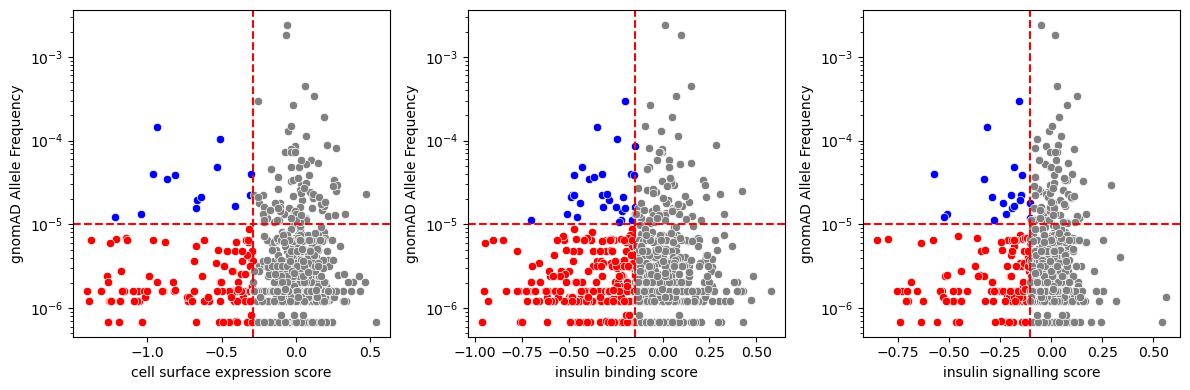

In [12]:
name_map = {
    'insBind_avg_scores': 'insulin binding score',
    'insSign_avg_scores': 'insulin signalling score',
    'a07a14_Bind_avg_scores': 'cell surface expression score',
    'comp_sum_scores': 'comp sum scores',
    'comp_min_scores': 'comp min scores'}

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each analysis
for i, analysis in enumerate(['a07a14_Bind_avg_scores', 'insBind_avg_scores', 'insSign_avg_scores']):
    
    # Define the vertical lines for each analysis
    if analysis == 'a07a14_Bind_avg_scores':
        x_threshold = -0.29
    elif analysis == 'insBind_avg_scores':
        x_threshold = -0.146
    elif analysis == 'insSign_avg_scores':
        x_threshold = -0.103

    # Create masks for coloring points
    mask_below_threshold = (gnomAD_scored_all[analysis] < x_threshold)
    mask_above_threshold = ~mask_below_threshold
    mask_above_allele_freq = (gnomAD_scored_all['Allele Frequency'] > 0.00001)
    mask_below_allele_freq = ~mask_above_allele_freq

    # Points below threshold and Allele Frequency > 0.00001 (Blue)
    mask_blue = mask_below_threshold & mask_above_allele_freq
    # Points below threshold and Allele Frequency <= 0.00001 (Red)
    mask_red = mask_below_threshold & mask_below_allele_freq
    # Points above threshold (Grey)
    mask_grey = mask_above_threshold

    # Plot points below threshold with Allele Frequency > 0.00001 in blue
    sns.scatterplot(x=gnomAD_scored_all[analysis][mask_blue], 
                    y=gnomAD_scored_all['Allele Frequency'][mask_blue], 
                    ax=axes[i], color='blue')

    # Plot points below threshold with Allele Frequency <= 0.00001 in red
    sns.scatterplot(x=gnomAD_scored_all[analysis][mask_red], 
                    y=gnomAD_scored_all['Allele Frequency'][mask_red], 
                    ax=axes[i], color='red')

    # Plot points above threshold in grey
    sns.scatterplot(x=gnomAD_scored_all[analysis][mask_grey], 
                    y=gnomAD_scored_all['Allele Frequency'][mask_grey], 
                    ax=axes[i], color='grey')
    
    axes[i].set_ylabel('gnomAD Allele Frequency')
    axes[i].set_xlabel(name_map[analysis])
    axes[i].set_yscale('log')  # Set the y-axis scale to logarithmic
    axes[i].axhline(0.00001, color='r', linestyle='--')
    axes[i].axvline(x_threshold, color='r', linestyle='--')


plt.tight_layout()
plt.savefig('results/figures/SuppFig8ABC.pdf')
plt.show()

/var/folders/7h/2q6hn63j55q0tvl9pl78llgw0000gn/T/ipykernel_85023/3291112925.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomAD_scored_hom.dropna(subset=['comp_min_scores'], inplace=True)


97
97
DS_RMS_TA, count 88


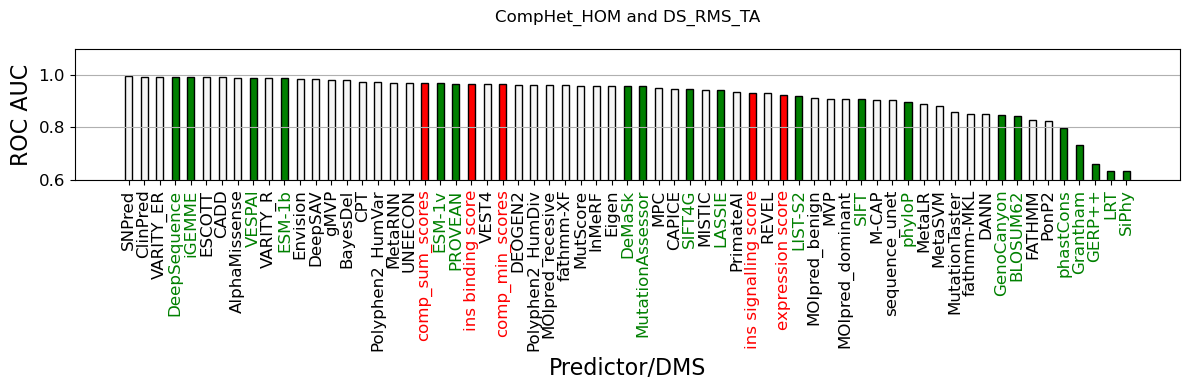

48
48
DS_RMS_TA, count 39


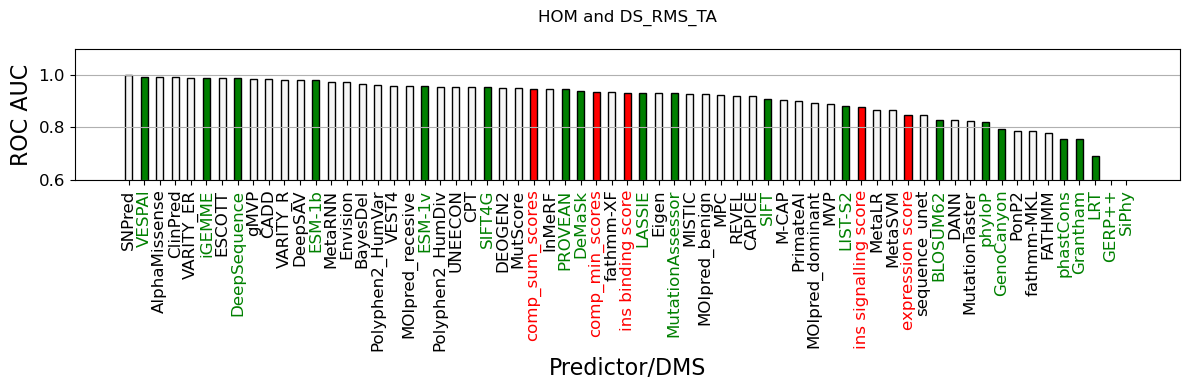

83
83
DS_RMS, count 74


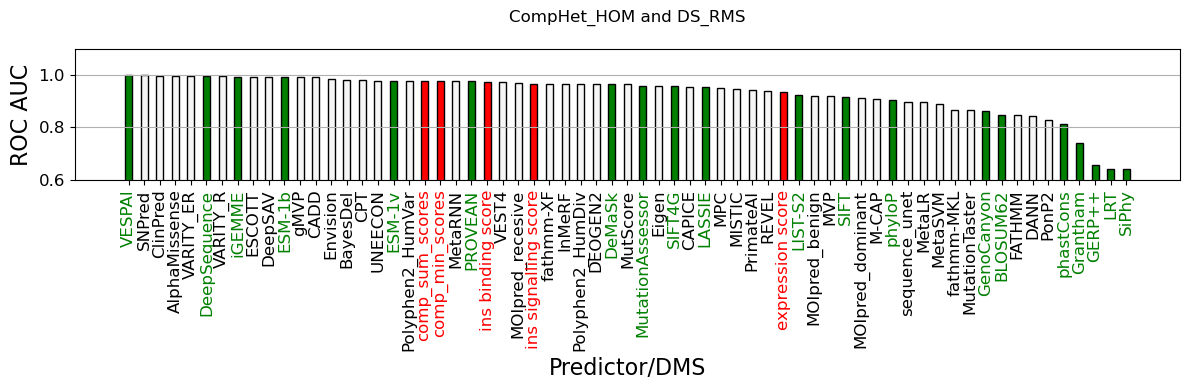

42
42
DS_RMS, count 33


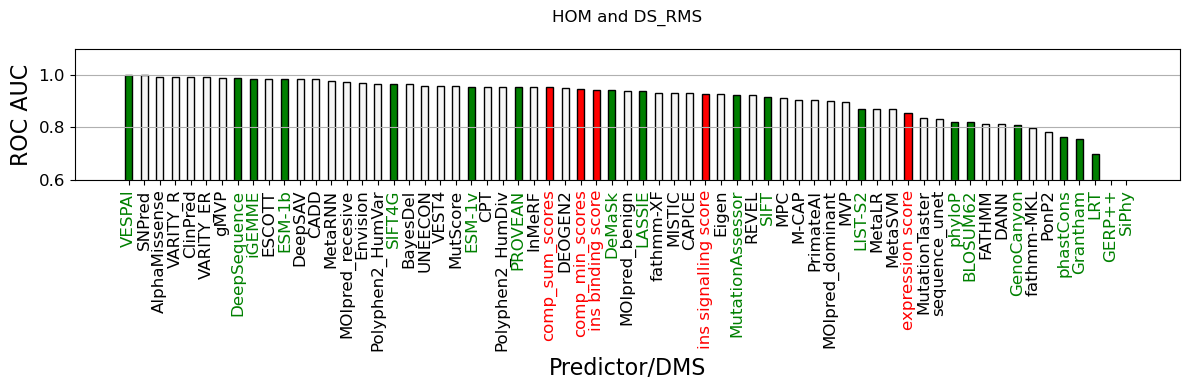

45
45
DS, count 36


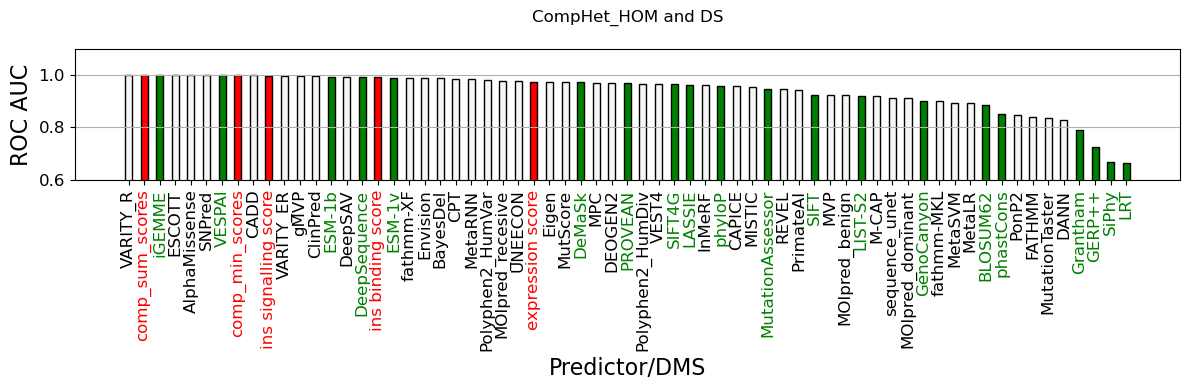

29
29
DS, count 20


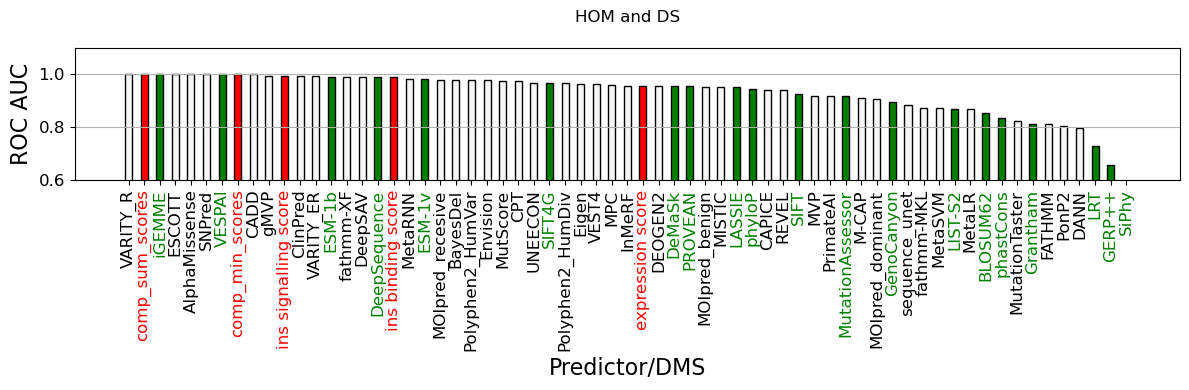

47
47
RMS, count 38


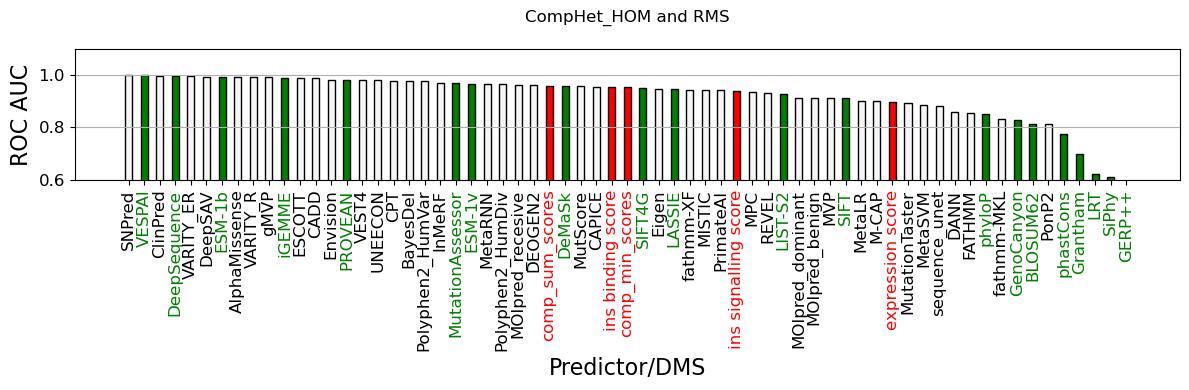

In [13]:
invert = ['BLOSUM62','SIFT','SIFT4G','LRT','FATHMM','PROVEAN','Envision','mutationTCN',
'ESM-1v','DeepSequence','fitCons', 'EVmutation_epistatic','EVmutation_independent',
         'COSMIS','ESM-1b','DeMaSk','MOIpred_benign','ESCOTT','iGEMME',
          'a07a14_Bind_avg_scores','insSign_avg_scores','insBind_avg_scores',
          'comp_sum_scores','comp_min_scores']

unsupervised = ['LIST-S2','ESM-1v','EVE','DeepSequence','MutationAssessor','PROVEAN','SIFT','SIFT4G','phyloP','SiPhy',
               'fitCons','phastCons','BLOSUM62','GERP++','Grantham','LRT','GenoCanyon','EVmutation_epistatic','EVmutation_independent',
               'VESPAl','mutationTCN','LASSIE','EVmutation_epistatic','EVmutation_independent',
               'ESM-1b','DeMaSk','iGEMME']

scores=['SIFT', 'SIFT4G', 'Polyphen2_HumDiv', 'Polyphen2_HumVar', 'LRT',
       'MutationTaster', 'MutationAssessor', 'FATHMM', 'PROVEAN', 'VEST4',
       'MetaSVM', 'MetaLR', 'M-CAP', 'REVEL', 'MutPred', 'MVP', 'MPC',
       'PrimateAI', 'DEOGEN2', 'CADD', 'DANN', 'fathmm-MKL', 'fathmm-XF',
       'Eigen', 'GenoCanyon', 'GERP++', 'phyloP', 'phastCons', 'SiPhy',
       'MetaRNN', 'BayesDel', 'ClinPred', 'LIST-S2', 'LINSIGHT', 'VARITY_R',
       'VARITY_ER', 'Envision', 'PonP2', 'EVE', 'VESPAl', 'mutationTCN',
       'BLOSUM62', 'Grantham', 'CPT', 'DeepSAV', 'sequence_unet', 'LASSIE',
       'ESM-1v', 'DeepSequence', 'EVmutation_epistatic',
       'EVmutation_independent', 'COSMIS', 'ESM-1b', 'Rhapsody', 'CAPICE',
       'InMeRF', 'DeMaSk', 'MOIpred_benign', 'MOIpred_dominant',
       'MOIpred_recesive', 'gMVP', 'MISTIC', 'UNEECON', 'SNPred',
       'AlphaMissense', 'ESCOTT', 'iGEMME', 'MutScore','a07a14_Bind_avg_scores',
         'insSign_avg_scores','insBind_avg_scores','comp_sum_scores','comp_min_scores','CLASS']

filtDict={
    'DS_RMS_TA___CompHet_HOM': 73,
    'DS_RMS___CompHet_HOM': 63,
    'DS_RMS_TA___HOM': 36,
    'DS_RMS___HOM': 31,
    'DS___CompHet_HOM': 32,
    'DS___HOM': 20,
    'RMS___CompHet_HOM': 31,

}

patient_db.dropna(subset=['comp_min_scores'], inplace=True)
gnomAD_scored_hom.dropna(subset=['comp_min_scores'], inplace=True)

for disease in ['DS_RMS_TA','DS_RMS', 'DS', 'RMS', 'TA']:
    for designation in ['CompHet_HOM', 'HOM']:
        
        filtKey=f'{disease}___{designation}'

        if filtKey in ['TA___HOM','RMS___HOM','TA___CompHet_HOM']:
            continue
        
        #get the scored patient data
        patient_data=patient_db.copy()
        
        #filtering based on disease or designation
        disease_type=disease
        designation_type=designation

        if designation_type == 'HOM':
            patient_data=patient_data[patient_data['designation']==designation_type]

        if disease_type == 'DS_RMS_TA':
            patient_data=patient_data[patient_data['phenotype'].isin(['DS','RMS','TA'])]
            
        elif disease_type == 'DS_RMS':
            patient_data=patient_data[patient_data['phenotype']!='TA']
            
        else:
            patient_data=patient_data[patient_data['phenotype']==disease_type]

            
        
        #select relevent columns and assign CLASS==1 as pathogenic
        patient_data=patient_data[scores]
        gnomAD_data=gnomAD_scored_hom[scores]
        

        subset = pd.concat([gnomAD_data, patient_data])

        print (len(subset))
        #drop duplicates like A119V with two stop in ecctodomain would be the same thing
        #subset.drop_duplicates(inplace=True)
        #subset.drop('aa_substitutions', axis=1, inplace=True)

        print (len(subset))
        data=subset

        results = {}
        for col in data.columns:
            
            if col != 'CLASS':
                col_subset = data[[col,'CLASS']].dropna() #remove vep_data outside of gnomAD and patient_db
                num_pathogenic = len(col_subset[col_subset['CLASS']==1])
                num_benign = len(col_subset[col_subset['CLASS']==0])
                
                      
                if num_pathogenic < filtDict[filtKey]  or num_benign < 9:
                    continue
                    
                    
                if col in invert:
                    col_subset[col] = pd.to_numeric(col_subset[col])  # Convert to numeric
                    col_subset[col] = min(col_subset[col]) - col_subset[col] + max(col_subset[col])

        
                ROC = roc_auc_score(col_subset['CLASS'],col_subset[col])
                results[col] = [ROC]
        
                PR = average_precision_score(col_subset['CLASS'],col_subset[col])
                results[col].append(PR)
        
                prior = num_pathogenic / (num_pathogenic + num_benign)
                BPR = (PR * (1-prior))/(PR*(1-prior)+(1-PR)*prior)
                results[col].append(BPR)
        
        results = pd.DataFrame.from_dict(results,orient='index')
        results.columns = ['AUROC','AUPRC','AUBPRC']
        results.sort_values(['AUROC'],ascending=False,inplace=True)
        results.to_csv(OUT_dir+'classifier_results_full_data.csv')


        # Plot both the raw ROC and ranks in bar charts
        plot = graphit2.plot((1,1),figsize=(12,4))

#

        ROC_data = pd.read_csv(OUT_dir+'classifier_results_full_data.csv',index_col='Unnamed: 0')
        ROC_data = ROC_data.sort_values(['AUROC'],ascending=False)

        cols = []
        for predictor in list(ROC_data.index):
            if predictor in unsupervised:
                cols.append(unsupervised_colour)
            elif '_scores' in predictor:
                cols.append(DMS_colour)
            else:
                cols.append(supervised_colour)
        axes_dict = {'xtick_rotation':90,'xticksize':12,'yticksize':12}

        plot.single_bar(ROC_data['AUROC'],extract=True,ylim=(0.6,1.1),width=0.45,axes_dict=axes_dict,colour=cols,
                        edgecolour='black',xlabel='Predictor/DMS::16',ylabel='ROC AUC::16')
        plt.grid(axis='y')
        
        ax = plt.gca()
        xtick_labels = ax.get_xticklabels() 
        new_labels = []
        for label in xtick_labels:
            text = label.get_text()
            if text == 'comp_sum_scores' or text ==  'comp_min_scores':
                label.set_color('red')
            if text == 'a07a14_Bind_avg_scores':
                label.set_color('red')
                text = 'expression score'
            if text == 'insSign_avg_scores':
                text = ('ins signalling score')
                label.set_color('red')
            if text == 'insBind_avg_scores':
                text = ('ins binding score')
                label.set_color('red')
            if text in unsupervised:
            # Add a star to the label text
                label.set_color('green')
                        
            
            new_labels.append(text)
            #print (new_labels)
        
        ax.set_xticklabels(new_labels)

        plt.title(f'{designation_type} and {disease_type}\n')
        plot.save(OUT_dir+f'ROC_{designation_type}_{disease_type}.pdf',format='pdf',dpi=600)
        print (f'{disease_type}, count {len(patient_data)}')
        plot.show()

In [14]:
def parse_ClinVarMiner(f):
    data = pd.read_csv(f)
    data['aa_substitutions'] = data['HGVS'].apply(lambda x:parse_HGVS(x,pattern="p\.([A-Z][a-z]{2})([0-9]*)([A-Z][a-z]{2})"))
    data=data.dropna(subset=['aa_substitutions'])
    data=data[data['aa_substitutions'].str[1:-1].astype(int).lt(955)] #only keep extracellular variants
    data=data[data['aa_substitutions'].str[1:-1].astype(int).ge(27)]
    return data


VUS = parse_ClinVarMiner('input_files/ClinVarMiner_VUS.csv')

VUS_scored=pd.merge(VUS,var_score, on='aa_substitutions')

VUS_scored['comp_sum']=VUS_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].sum(axis=1)
VUS_scored['comp_min']=VUS_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].min(axis=1) #

In [15]:
ClinVar_VUS = parse_ClinVarMiner('input_files/ClinVarMiner_VUS.csv')
ClinVarBenign = parse_ClinVarMiner('input_files/ClinVarMiner_benignORLikBenign.csv')
ClinVarPathog = parse_ClinVarMiner('input_files/clinvar_pathogenic_AND_LkelyPathogenic.csv') #check this if, included likley pathogenic?????????????

ClinVar_VUS = ClinVar_VUS.loc[~ClinVar_VUS['aa_substitutions'].str.endswith('*')]
ClinVarBenign = ClinVarBenign.loc[~ClinVarBenign['aa_substitutions'].str.endswith('*')]
ClinVarPathog = ClinVarPathog.loc[~ClinVarPathog['aa_substitutions'].str.endswith('*')]

ClinVar_VUS.drop_duplicates(subset=['aa_substitutions'], inplace=True)
ClinVarBenign.drop_duplicates(subset=['aa_substitutions'], inplace=True)
ClinVarPathog.drop_duplicates(subset=['aa_substitutions'], inplace=True)

VUS_scored=pd.merge(ClinVar_VUS,var_score, on='aa_substitutions')
VUS_scored.drop_duplicates(subset=['aa_substitutions'], inplace=True)
VUS_scored['comp_sum']=VUS_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].sum(axis=1)
VUS_scored['comp_min']=VUS_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].min(axis=1) 

ClinVarBenign_scored=pd.merge(ClinVarBenign,var_score, on='aa_substitutions')
ClinVarBenign_scored.drop_duplicates(subset=['aa_substitutions'], inplace=True)
ClinVarBenign_scored['comp_sum']=ClinVarBenign_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].sum(axis=1)
ClinVarBenign_scored['comp_min']=ClinVarBenign_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].min(axis=1)

ClinVarPathog_scored=pd.merge(ClinVarPathog,var_score, on='aa_substitutions')
ClinVarPathog_scored.drop_duplicates(subset=['aa_substitutions'], inplace=True)
ClinVarPathog_scored['comp_sum']=ClinVarPathog_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].sum(axis=1)
ClinVarPathog_scored['comp_min']=ClinVarPathog_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].min(axis=1)

In [59]:
ClinVar_VUS = parse_ClinVarMiner('input_files/ClinVarMiner_VUS.csv')
ClinVarBenign = parse_ClinVarMiner('input_files/ClinVarMiner_benignORLikBenign.csv')
ClinVarPathog = parse_ClinVarMiner('input_files/clinvar_pathogenic_AND_LkelyPathogenic.csv') #check this if, included likley pathogenic?????????????

ClinVar_VUS = ClinVar_VUS.loc[~ClinVar_VUS['aa_substitutions'].str.endswith('*')]
ClinVarBenign = ClinVarBenign.loc[~ClinVarBenign['aa_substitutions'].str.endswith('*')]
ClinVarPathog = ClinVarPathog.loc[~ClinVarPathog['aa_substitutions'].str.endswith('*')]

b=np.unique(ClinVarBenign['aa_substitutions'])
p=np.unique(ClinVarPathog['aa_substitutions'])
v=np.unique(ClinVar_VUS['aa_substitutions'])

m=n=0
for i,j in zip(b,p):
    if i in v:
        print ('Benign in VUS: '+i)
        m=m+1
    if j in v:
        print ('Pathogenic in VUS: '+j)
        n=n+1
print (m)
print (n)

print (len(b))
print (len(p))
print (len(v))

Benign in VUS: A663V
Pathogenic in VUS: A119V
Benign in VUS: A706D
Benign in VUS: D946E
Benign in VUS: E517G
Benign in VUS: E51K
Benign in VUS: G192D
Benign in VUS: P755S
Benign in VUS: R796S
Benign in VUS: R889W
Pathogenic in VUS: N489S
Benign in VUS: S748L
Benign in VUS: T320M
Benign in VUS: T858M
12
2
18
21
102


in response to this comment "Fig. 5A would benefit from addition of at least a subset of WT INSR alongside DS/RMS/TA under Phenotypes. This might include, for example, synonymous mutations at the same residues associated with DS/RMS/TA." 

Took all the synonymous barcode scores with mean for each assay and then grouped them based on codon_substitutions and calculated mean again. also extracted all the disease phenotype missense variants and their positions. Using this position list, found all the synonymous events that happening in those positions. Then plotted scores distributions for those positions and also for all the pathogenic variants.


In [60]:
barcode_scores = pd.read_csv('results/scores/barcode_scores.csv')
# Load barcode-level scores
barcode_scores = pd.read_csv('results/scores/barcode_scores.csv')

# Filter barcode scores by variant class
synonymous_variants = barcode_scores[barcode_scores['variant_class'] == 'synonymous']
wildtype_variants = barcode_scores[barcode_scores['variant_class'] == 'wildtype']

# Get all unique patient variants from both alleles
patient_variants = pd.Series(
    list(patient_db['allel_1'].unique()) + list(patient_db['allel_2'].unique())
).dropna().unique()

# Extract positions from variants (e.g., "R123H" -> 123)
patient_variant_positions = [int(v[1:-1]) for v in patient_variants]

# Filter barcode scores for patient variants
patient_variant_scores = barcode_scores[barcode_scores['aa_substitutions'].isin(patient_variants)]

# Get numeric columns for aggregation
numeric_cols = patient_variant_scores.select_dtypes(include='number').columns

# Group by aa_substitutions and calculate means
patient_grouped_means = patient_variant_scores.groupby('aa_substitutions')[numeric_cols].mean()

# Log2 normalize by wildtype mean
wildtype_means = wildtype_variants[numeric_cols].mean()
patient_grouped_means[numeric_cols] = np.log2(patient_grouped_means[numeric_cols] / wildtype_means.values)

merged_synonymous = pd.merge(variants, synonymous_variants, on='barcode', how='right')
merged_synonymous

,target,library,barcode,variant_call_support,number_of_indels,codon_substitutions_x,aa_substitutions_x,n_codon_substitutions,n_aa_substitutions,variant_class_x,...,insulin_binding_mean,mAb83-7_binding_mean,mAb83-14_binding_mean,insulin_signalling_mean,mAb83-7_signalling_mean,mAb83-14_signalling_mean,position,mAb83-7_mAb83-14_binding_mean,mAb83-7_mAb83-14_signalling_mean,variant_class_y
0,INSR_PacBio_amplicon,insr,AAAAAAAAGAATCATATAGATAACGAACAG,7,0,GTT218GTG,,1,0,synonymous,...,0.624903,0.690947,0.719132,0.626923,0.785452,0.648902,ynonymou,0.705039,0.703522,synonymous
1,INSR_PacBio_amplicon,insr,AAAAAAAAGCCTATAGTTAGGAAACCATAG,8,0,TCC810TCG,,1,0,synonymous,...,0.801696,0.623080,0.699456,0.649864,0.648610,0.624150,ynonymou,0.661268,0.636380,synonymous
2,INSR_PacBio_amplicon,insr,AAAAAACCAAACATCGCGCCAATTCTATAA,24,0,AGC787TCG,,1,0,synonymous,...,0.509237,0.464763,0.406196,0.564654,0.574230,0.490752,ynonymou,0.435480,0.532491,synonymous
3,INSR_PacBio_amplicon,insr,AAAAAAGCTTCACTAGCCCAAACAGTGATG,9,0,CGA525AGG,,1,0,synonymous,...,0.617186,0.545524,0.501640,0.623386,0.638390,0.548129,ynonymou,0.523582,0.593259,synonymous
4,INSR_PacBio_amplicon,insr,AAAAACAAACTTTATAAGTAAAAAGCGACA,10,0,CCC743CCG,,1,0,synonymous,...,NaN,NaN,NaN,NaN,NaN,0.463114,ynonymou,NaN,0.463114,synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,INSR_PacBio_amplicon,insr,TTTTCATTGTTTTGAACAAATCCCCAAATT,8,0,CCG918CCC,,1,0,synonymous,...,0.702708,0.649624,0.684188,0.666363,0.642184,0.666273,ynonymou,0.666906,0.654229,synonymous
3228,INSR_PacBio_amplicon,insr,TTTTGAGCTTTTCCTTGTATGTTTTAAAGT,7,0,ACC199ACG,,1,0,synonymous,...,0.654083,0.651940,0.671863,0.664099,0.708725,0.694109,ynonymou,0.661901,0.701417,synonymous
3229,INSR_PacBio_amplicon,insr,TTTTGGAAGATTACTTTTCAAGAGCTGTAA,11,0,AAA460AAG,,1,0,synonymous,...,0.404029,0.305539,0.313073,0.501987,0.490710,0.475281,ynonymou,0.309306,0.482996,synonymous
3230,INSR_PacBio_amplicon,insr,TTTTGTCGAAGGCCGTGATTCAATCCTGAA,5,0,TGT186TGC,,1,0,synonymous,...,0.850375,0.816670,0.739357,0.612878,0.662634,0.680158,ynonymou,0.778013,0.671396,synonymous


,target,library,barcode,variant_call_support,number_of_indels,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,variant_class,aa_substitutions_c
0,INSR_PacBio_amplicon,insr,AATGGCGAATTATCTACAGCCATTTTTTTT,5,0,,,0,0,wildtype,wildtype
1,INSR_PacBio_amplicon,insr,ATCAAACAAAGCACCGATCACATTTTTTTT,9,0,GAA938GCC,E938A,1,1,1 nonsynonymous,E938A
2,INSR_PacBio_amplicon,insr,GACAAGAAGCACTTGGTTAAATGTTTTTTT,19,0,,,0,0,wildtype,wildtype
3,INSR_PacBio_amplicon,insr,GGGGGAGCTGAGGCGCCTAGTAATTTTTTT,1,0,TCC711TCG,,1,0,synonymous,synonymous
4,INSR_PacBio_amplicon,insr,GACTTGGAAAAACTCAGTTGATCGTTTTTT,31,0,AAG337CTC,K337L,1,1,1 nonsynonymous,K337L
...,...,...,...,...,...,...,...,...,...,...,...
126222,INSR_PacBio_amplicon,insr,CCGTAGACTCTGCTAGCAATAAAAAAAAAA,14,0,,,0,0,wildtype,wildtype
126223,INSR_PacBio_amplicon,insr,TTGGACGTGATCCGTCGAAGAAAAAAAAAA,18,0,AGG912CCC,R912P,1,1,1 nonsynonymous,R912P
126224,INSR_PacBio_amplicon,insr,ACAGCTGAGTGGAGACACGCAAAAAAAAAA,14,0,GCC198GTC,A198V,1,1,1 nonsynonymous,A198V
126225,INSR_PacBio_amplicon,insr,ATAAGGTAACCTGTCGGGGAAAAAAAAAAA,19,0,CAG216TAG,Q216*,1,1,stop,Q216*


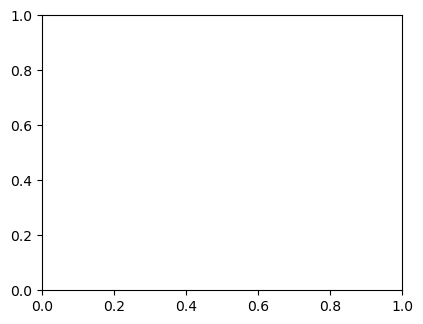

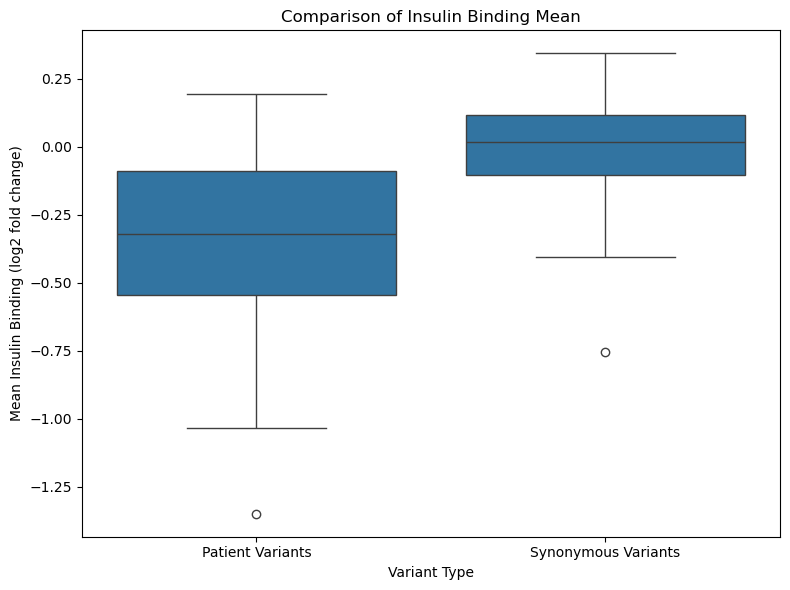

In [61]:
# Load barcode-level scores
barcode_scores = pd.read_csv('results/scores/barcode_scores.csv')


# Filter barcode scores by variant class
synonymous_variants = barcode_scores[barcode_scores['variant_class'] == 'synonymous']
wildtype_variants = barcode_scores[barcode_scores['variant_class'] == 'wildtype']

# Get all unique patient variants from both alleles
patient_variants = pd.Series(
    list(patient_db['allel_1'].unique()) + list(patient_db['allel_2'].unique())
).dropna().unique()

# Extract positions from variants (e.g., "R123H" -> 123)
patient_variant_positions = [int(v[1:-1]) for v in patient_variants]

# Filter barcode scores for patient variants
patient_variant_scores = barcode_scores[barcode_scores['aa_substitutions'].isin(patient_variants)]

# Get numeric columns for aggregation
numeric_cols = patient_variant_scores.select_dtypes(include='number').columns

# Group by aa_substitutions and calculate means
patient_grouped_means = patient_variant_scores.groupby('aa_substitutions')[numeric_cols].mean()

# Log2 normalize by wildtype mean
wildtype_means = wildtype_variants[numeric_cols].mean()
patient_grouped_means[numeric_cols] = np.log2(patient_grouped_means[numeric_cols] / wildtype_means.values)

# Merge synonymous data with variant annotation
merged_synonymous = pd.merge(variants[variants['n_codon_substitutions']==1], synonymous_variants, on='barcode', how='right')

# Group by codon_substitutions and compute means
synonymous_grouped_means = merged_synonymous.groupby('codon_substitutions_x')[numeric_cols].mean().reset_index()

# Log2 normalize synonymous scores
synonymous_grouped_means[numeric_cols] = np.log2(synonymous_grouped_means[numeric_cols] / wildtype_means.values)

# Extract position from codon substitution (e.g., "AAA123GGG" -> 123)
synonymous_grouped_means['position'] = synonymous_grouped_means['codon_substitutions_x'].apply(lambda x: int(x[3:-3]))

# Filter to include only patient-related positions
synonymous_grouped_means = synonymous_grouped_means[synonymous_grouped_means['position'].isin(patient_variant_positions)]

synonymous_grouped_means_plotting=synonymous_grouped_means.copy()
synonymous_grouped_means_plotting.rename(columns={'mAb83-7_mAb83-14_binding_mean': 'a07a14_Bind_avg_scores'}, inplace=True)
synonymous_grouped_means_plotting.rename(columns={'insulin_binding_mean': 'insBind_avg_scores'}, inplace=True)
synonymous_grouped_means_plotting.rename(columns={'insulin_signalling_mean': 'insSign_avg_scores'}, inplace=True)
synonymous_grouped_means_plotting['comp_sum_scores'] = synonymous_grouped_means_plotting[['insBind_avg_scores', 'insSign_avg_scores', 'a07a14_Bind_avg_scores']].sum(axis=1)
synonymous_grouped_means_plotting['comp_min_scores'] = synonymous_grouped_means_plotting[['insBind_avg_scores', 'insSign_avg_scores', 'a07a14_Bind_avg_scores']].min(axis=1)

# Prepare data for plotting
df_patient_insBind_avg = patient_grouped_means[['insulin_binding_mean']].copy()

df_patient_insBind_avg['source'] = 'Patient Variants'

df_synonymous = synonymous_grouped_means[['insulin_binding_mean']].copy()
df_synonymous['source'] = 'Synonymous Variants'

plot_data = pd.concat([df_patient_insBind_avg, df_synonymous], ignore_index=True)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='source', y='insulin_binding_mean', data=plot_data)
plt.title('Comparison of Insulin Binding Mean')
plt.ylabel('Mean Insulin Binding (log2 fold change)')
plt.xlabel('Variant Type')
plt.tight_layout()
plt.show()

In [62]:
#cutoffs from Supplementary Figure 7

exp_cutoff=-0.294
insBind_cutoff=-0.146
insSign_cutoff=-0.103

In [63]:

name_map = {
    'aa_substitutions': 'synonymous codon substitutions',
    'insBind_avg': 'Insulin binding score',
    'insSign_avg': 'Insulin signalling score',
    'a07a14_Bind_avg': 'Cell surface expression score',
    'comp_sum': 'Comp sum scores',
    'comp_min': 'Comp min scores',
  }

variants = pd.read_csv(f'results/variants/codon_variant_table.csv', na_filter=None)

variants_score_syns=pd.read_csv('results/scores/syonymouse_variants_scores.csv')
variants_score_syns['comp_sum'] = variants_score_syns[['insBind_avg', 'insSign_avg', 'a07a14_Bind_avg']].sum(axis=1)
variants_score_syns['position'] = variants_score_syns['aa_substitutions'].apply(lambda x: int(x[3:-3]))

# Get all unique patient variants from both alleles
patient_variants = pd.Series(
    list(patient_db['allel_1'].unique()) + list(patient_db['allel_2'].unique())
).dropna().unique()

# Extract positions from variants (e.g., "R123H" -> 123)
patient_variant_positions = [int(v[1:-1]) for v in patient_variants]

variants_score_syns = variants_score_syns[variants_score_syns['position'].isin(patient_variant_positions)]



variants_score_syns.to_csv('results/scores/syonymouse_variants_scores_InPathogenicPositions.csv', index=False)

for library in ['insBind_avg', 'insSign_avg', 'a07a14_Bind_avg']:
    # Read FDR dataframe for the current library
    fdr_df = pd.read_csv(f"results/bootstraps/{library}_BArcodeScoresWithFDR_syn.csv")
    
    # Assume fdr_df has columns: 'aa_substitutions' and 'FDR'
    # Set index to 'aa_substitutions' for quick lookup
    fdr_df = fdr_df.set_index('aa_substitutions')
    
    # Map FDR values to variants_score_syns based on aa_substitutions
    variants_score_syns[f"{library}_FDR"] = variants_score_syns['aa_substitutions'].map(fdr_df['FDRvalues'])

variants_score_syns.drop(columns=['a07Bind_avg', 'a14Bind_avg'], inplace=True)


variants_score_syns_save=variants_score_syns.copy()
# Rename score columns using the name_map
variants_score_syns_save.rename(columns=name_map, inplace=True)

# Now rename corresponding FDR columns: replace 'score' with 'FDR' in the mapped names
fdr_name_map = {
    f"{key}_FDR": name.replace('score', 'FDR') 
    for key, name in name_map.items()
}

variants_score_syns_save.rename(columns=fdr_name_map, inplace=True)


variants_score_syns_save.to_csv('results/scores/syonymouse_variants_scores_InPathogenicPositions.csv', index=False)


Cell surface expression score
15 96 19 777 9 87 36 38 14
DS vs HOM: p-value = 4.30769051084069e-16
RMS vs HOM: p-value = 6.150410376276302e-11
TA vs HOM: p-value = 3.9047168627922614e-05
VUS vs HOM: p-value = 0.7759054718772974
pathog vs HOM: p-value = 0.048040417282187324
Insulin binding score
15 96 19 766 9 85 35 38 13
DS vs HOM: p-value = 1.7344425849651292e-16
RMS vs HOM: p-value = 1.0622847937544178e-14
TA vs HOM: p-value = 8.537100784763517e-06
VUS vs HOM: p-value = 0.2886892644258777
pathog vs HOM: p-value = 0.013793665923751012
Insulin signalling score
15 96 19 777 9 86 36 38 13
DS vs HOM: p-value = 5.632291602561188e-17
RMS vs HOM: p-value = 1.0579211044801817e-13
TA vs HOM: p-value = 0.008371963244380219
VUS vs HOM: p-value = 0.7561526307199234
pathog vs HOM: p-value = 0.16532715423132338
Comp sum scores
15 96 19 887 9 88 36 38 14
DS vs HOM: p-value = 1.001054338692571e-17
RMS vs HOM: p-value = 7.283936734211581e-15
TA vs HOM: p-value = 7.529675396015077e-06
VUS vs HOM: p-val

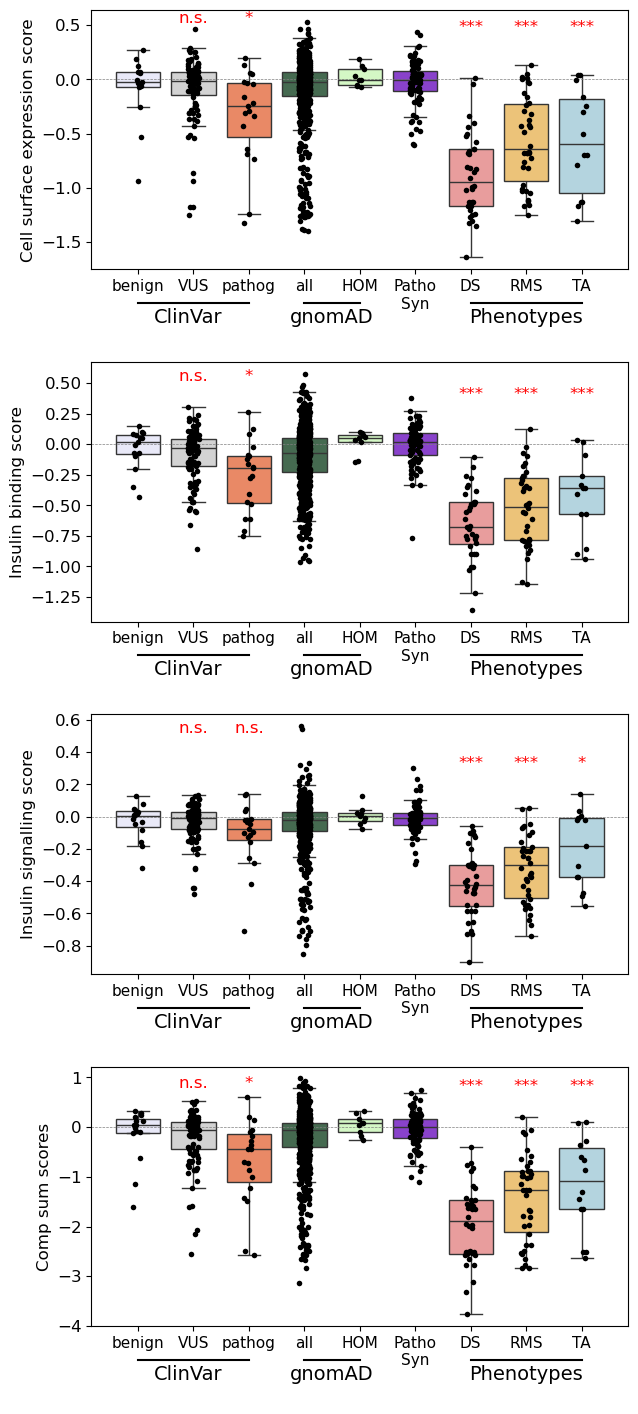

In [65]:
def annotate_dataVUS(ax, dataVUS, aa_substitutions, scores):
    for i, score in enumerate(scores):
        if score < -0.5:
            ax.annotate(aa_substitutions[i], (dataVUS[i], i), textcoords="offset points", xytext=(0,10), ha='center')


cols = ['a07a14_Bind_avg_scores', 'insBind_avg_scores', 'insSign_avg_scores', 'comp_sum_scores']

df=patient_db.copy()
df1=gnomAD_scored_hom.copy()

df1[cols] = df1[cols].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(12, 17))
plt.subplots_adjust(hspace=0.15, wspace=0.15)

gnomAD_gain = []
gnomAD_loss = []

for i, score in enumerate(cols):
    ax = plt.subplot(5, 2, i * 2 + 1)

    
    print (name_map[score[:-7]])

    
    dataClinBenign = list(ClinVarBenign_scored[score[:-7]].dropna())
    dataClinPathpo = list(ClinVarPathog_scored[score[:-7]].dropna())

    dataVUS = list(VUS_scored[score[:-7]].dropna())
    data0 = list(gnomAD_scored_all[score].dropna())
    data1 = list(df1[score].dropna())
    data_syn = list(variants_score_syns[score[:-7]].dropna())
    data2 = list(df[df['phenotype'] == 'DS'][score].dropna())
    data3 = list(df[df['phenotype'] == 'RMS'][score].dropna())
    data4 = list(df[df['phenotype'] == 'TA'][score].dropna())
    
    gnomAD_filt=gnomAD_scored_all.dropna(subset=[score])
    
    gain_cutoff=0.75
    loss_cutoff=-2.5
    
        

    data_ALL = [dataClinBenign,dataVUS, dataClinPathpo, data0, data1,data_syn, data2, data3, data4]

    print (len(data_ALL[0]), len(data_ALL[1]), len(data_ALL[2]), len(data_ALL[3]), len(data_ALL[4]), len(data_ALL[5]), len(data_ALL[6]), len(data_ALL[7]), len(data_ALL[8]))

    
    sns.boxplot(data_ALL, showfliers = False, ax=ax, palette=['#E6E6FA','lightgrey','#FF7F50','#3F704D','#D1FFBD','#8A2BE2','#F59090','#FFC966','lightblue'])
    sns.stripplot(data_ALL, color='black', size=4, ax=ax)
    
    annotate_dataVUS(ax, dataVUS, list(VUS_scored['aa_substitutions'].dropna()), dataVUS)

    plt.axhline(0, linestyle='--', c='gray', lw=0.5)

    plt.xticks([0, 1, 2, 3, 4,5,6,7,8], ['benign','VUS','pathog','all','HOM','Patho\nSyn', 'DS', 'RMS', 'TA'], size=11)  # Adding x-axis labels
    plt.xlabel('\n ')
    plt.yticks(size=12)

    plt.ylabel(name_map[score[:-7]], size=12)
    #plt.title('Homozygous and CompHet variants', size=12)
    
    comparisons = [
    ('DS', data2, data_syn), 
    ('RMS', data3, data_syn), 
    ('TA', data4, data_syn), 
    ('VUS', dataVUS, dataClinBenign), 
    ('pathog', dataClinPathpo, dataClinBenign)
    ]

    # Define custom positions for each label
    positions = {
    'DS': 6,  # Last box
    'RMS': 7,  # Last box
    'TA': 8,  # Last box
    'VUS': 1,  # Second box
    'pathog': 2  # Third box
    }

    for label, data, benign_set in comparisons:
        stat, p_value = mannwhitneyu(benign_set, data)
        print(f"{label} vs HOM: p-value = {p_value}")

        # Determine the position for the annotation
        max_y = max(max(benign_set), max(data))   # A bit above the max value in benign_set or the compared data
        
        if label in ['VUS','pathog']:
            
            max_y = 0.52  # A bit above the max value in benign_set or the compared data

            if score == 'comp_sum_scores':
                max_y = 0.8


    
            
        annotation = None

        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.005:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = 'n.s.'

        if annotation and label in positions:
            # Use the predefined position for each label
            position = positions[label]
            ax.text(position, max_y, annotation, ha='center', color='red', size=12)
            
   
            
    x_positions = [0.9, 3.5, 7]  # Mid-points for each group
    group_labels = ['ClinVar', 'gnomAD', 'Phenotypes']
    group_ranges = [(0, 2), (3, 4), (6, 8)]  # Ranges corresponding to the labels

    for x, label, (start, end) in zip(x_positions, group_labels, group_ranges):
        # Draw a line below the group
        ax.plot([start, end], [-0.13, -0.13], transform=ax.get_xaxis_transform(), color='black', clip_on=False)
    
        # Add the label below the line
        ax.text(x, -0.185, label, ha='center', va='center', transform=ax.get_xaxis_transform(), fontsize=14)

        # Add padding to make space for the annotations
    plt.subplots_adjust(bottom=0.2)


    
plt.tight_layout()
plt.savefig('results/figures/Fig5A.pdf', dpi=300)
plt.show()


Cell surface expression score
[15, 96, 19, 777, 9, 87, 36, 38, 14]
DS vs HOM: P < 1.00e-17
RMS vs HOM: P < 7.28e-15
TA vs HOM: P < 7.53e-06
VUS vs HOM: P < 4.03e-01
pathog vs HOM: P < 1.83e-02
Insulin binding score
[15, 96, 19, 766, 9, 85, 35, 38, 13]
DS vs HOM: P < 1.00e-17
RMS vs HOM: P < 7.28e-15
TA vs HOM: P < 7.53e-06
VUS vs HOM: P < 4.03e-01
pathog vs HOM: P < 1.83e-02
Insulin signalling score
[15, 96, 19, 777, 9, 86, 36, 38, 13]
DS vs HOM: P < 1.00e-17
RMS vs HOM: P < 7.28e-15
TA vs HOM: P < 7.53e-06
VUS vs HOM: P < 4.03e-01
pathog vs HOM: P < 1.83e-02
Comp sum scores
[15, 96, 19, 887, 9, 88, 36, 38, 14]
DS vs HOM: P < 1.00e-17
RMS vs HOM: P < 7.28e-15
TA vs HOM: P < 7.53e-06
VUS vs HOM: P < 4.03e-01
pathog vs HOM: P < 1.83e-02


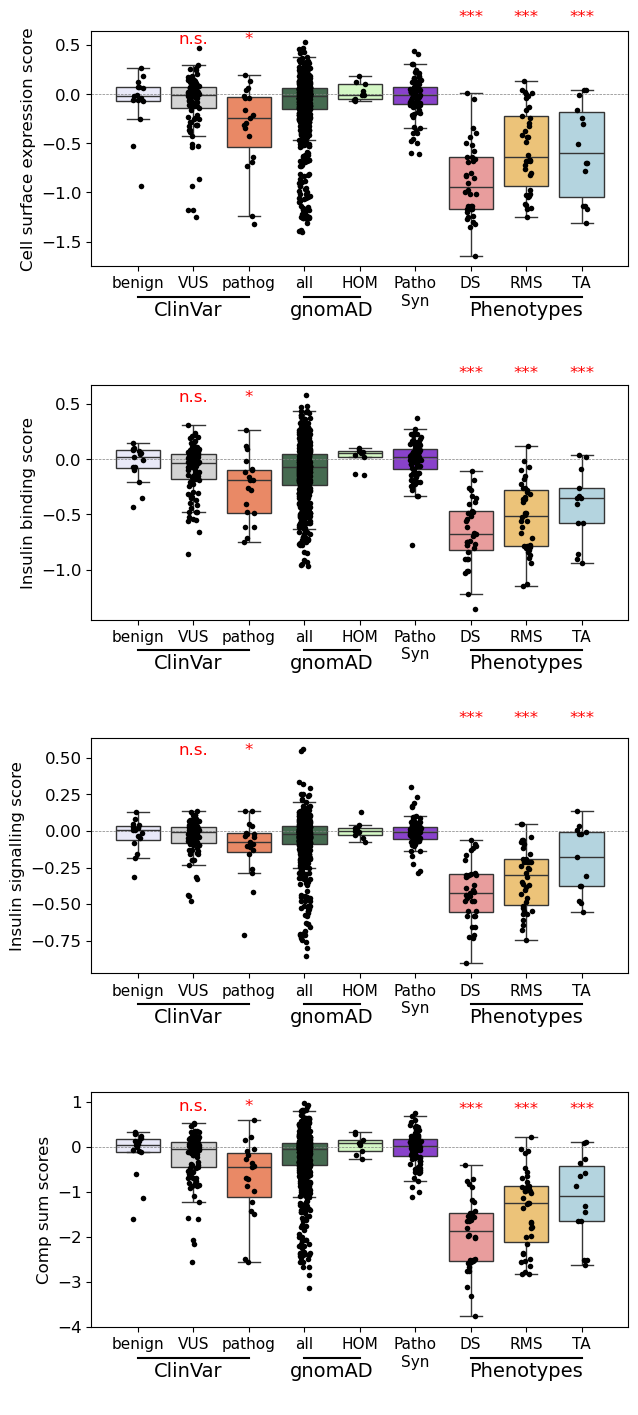

In [70]:
def annotate_dataVUS(ax, dataVUS, aa_substitutions, scores):
    for i, score in enumerate(scores):
        if score < -0.5:
            ax.annotate(aa_substitutions[i], (dataVUS[i], i), textcoords="offset points", xytext=(0,10), ha='center')

# Initialize a list to store all statistics
all_stats = []

cols = ['a07a14_Bind_avg_scores', 'insBind_avg_scores', 'insSign_avg_scores', 'comp_sum_scores']

df = patient_db.copy()
df1 = gnomAD_scored_hom.copy()
df1[cols] = df1[cols].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(12, 17))
plt.subplots_adjust(hspace=0.15, wspace=0.15)

for i, score in enumerate(cols):
    ax = plt.subplot(5, 2, i * 2 + 1)
    
    print(name_map[score[:-7]])
    
    # Get data for each group
    groups = {
        'benign': list(ClinVarBenign_scored[score[:-7]].dropna()),
        'VUS': list(VUS_scored[score[:-7]].dropna()),
        'pathog': list(ClinVarPathog_scored[score[:-7]].dropna()),
        'all': list(gnomAD_scored_all[score].dropna()),
        'HOM': list(df1[score].dropna()),
        'Patho_Syn': list(variants_score_syns[score[:-7]].dropna()),
        'DS': list(df[df['phenotype'] == 'DS'][score].dropna()),
        'RMS': list(df[df['phenotype'] == 'RMS'][score].dropna()),
        'TA': list(df[df['phenotype'] == 'TA'][score].dropna())
    }
    
    # Calculate statistics for each group
    for group_name, data in groups.items():
        if len(data) > 0:
            stats = {
                'score_name': name_map[score[:-7]],
                'score_column': score,
                'group': group_name,
                'n': len(data),
                'min': min(data),
                'max': max(data),
                'median': np.median(data),
                'q1': np.percentile(data, 25),
                'q3': np.percentile(data, 75),
                '5th_percentile': np.percentile(data, 5),
                '95th_percentile': np.percentile(data, 95),
                'mean': np.mean(data),
                'std': np.std(data)
            }
            all_stats.append(stats)
        else:
            print(f"No data available for {group_name} in {score}")

    data_ALL = list(groups.values())
    
    print([len(d) for d in data_ALL])

    sns.boxplot(data_ALL, showfliers = False, ax=ax, palette=['#E6E6FA','lightgrey','#FF7F50','#3F704D','#D1FFBD','#8A2BE2','#F59090','#FFC966','lightblue'])
    sns.stripplot(data_ALL, color='black', size=4, ax=ax)
    
    annotate_dataVUS(ax, dataVUS, list(VUS_scored['aa_substitutions'].dropna()), dataVUS)

    plt.axhline(0, linestyle='--', c='gray', lw=0.5)

    plt.xticks([0, 1, 2, 3, 4,5,6,7,8], ['benign','VUS','pathog','all','HOM','Patho\nSyn', 'DS', 'RMS', 'TA'], size=11)  # Adding x-axis labels
    plt.xlabel('\n ')
    plt.yticks(size=12)

    plt.ylabel(name_map[score[:-7]], size=12)
    #plt.title('Homozygous and CompHet variants', size=12)
    
    comparisons = [
    ('DS', data2, data_syn), 
    ('RMS', data3, data_syn), 
    ('TA', data4, data_syn), 
    ('VUS', dataVUS, dataClinBenign), 
    ('pathog', dataClinPathpo, dataClinBenign)
    ]

    # Define custom positions for each label
    positions = {
    'DS': 6,  # Last box
    'RMS': 7,  # Last box
    'TA': 8,  # Last box
    'VUS': 1,  # Second box
    'pathog': 2  # Third box
    }

    for label, data, benign_set in comparisons:
        stat, p_value = mannwhitneyu(benign_set, data)
        print(f"{label} vs HOM: P < {p_value:.2e}")

        # Determine the position for the annotation
        max_y = max(max(benign_set), max(data))   # A bit above the max value in benign_set or the compared data
        
        if label in ['VUS','pathog']:
            
            max_y = 0.52  # A bit above the max value in benign_set or the compared data

            if score == 'comp_sum_scores':
                max_y = 0.8


    
            
        annotation = None

        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.005:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = 'n.s.'

        if annotation and label in positions:
            # Use the predefined position for each label
            position = positions[label]
            ax.text(position, max_y, annotation, ha='center', color='red', size=12)
            
   
            
    x_positions = [0.9, 3.5, 7]  # Mid-points for each group
    group_labels = ['ClinVar', 'gnomAD', 'Phenotypes']
    group_ranges = [(0, 2), (3, 4), (6, 8)]  # Ranges corresponding to the labels

    for x, label, (start, end) in zip(x_positions, group_labels, group_ranges):
        # Draw a line below the group
        ax.plot([start, end], [-0.13, -0.13], transform=ax.get_xaxis_transform(), color='black', clip_on=False)
    
        # Add the label below the line
        ax.text(x, -0.185, label, ha='center', va='center', transform=ax.get_xaxis_transform(), fontsize=14)

        # Add padding to make space for the annotations
    plt.subplots_adjust(bottom=0.2)


    
# Convert statistics to DataFrame and save to CSV
stats_df = pd.DataFrame(all_stats)
stats_df.to_csv('results/figures/Fig5A_statistics.csv', index=False)

plt.tight_layout()
plt.savefig('results/figures/Fig5A.pdf', dpi=300)
plt.show()

Cell surface expression score
15 96 19 777 9 87 36 38 14
DS vs HOM: p-value = 4.30769051084069e-16
RMS vs HOM: p-value = 6.150410376276302e-11
TA vs HOM: p-value = 3.9047168627922614e-05
VUS vs HOM: p-value = 0.7759054718772974
pathog vs HOM: p-value = 0.048040417282187324
Insulin binding score
15 96 19 766 9 85 35 38 13
DS vs HOM: p-value = 1.7344425849651292e-16
RMS vs HOM: p-value = 1.0622847937544178e-14
TA vs HOM: p-value = 8.537100784763517e-06
VUS vs HOM: p-value = 0.2886892644258777
pathog vs HOM: p-value = 0.013793665923751012
Insulin signalling score
15 96 19 777 9 86 36 38 13
DS vs HOM: p-value = 5.632291602561188e-17
RMS vs HOM: p-value = 1.0579211044801817e-13
TA vs HOM: p-value = 0.008371963244380219
VUS vs HOM: p-value = 0.7561526307199234
pathog vs HOM: p-value = 0.16532715423132338
Comp sum scores
15 96 19 887 9 88 36 38 14
DS vs HOM: p-value = 1.001054338692571e-17
RMS vs HOM: p-value = 7.283936734211581e-15
TA vs HOM: p-value = 7.529675396015077e-06
VUS vs HOM: p-val

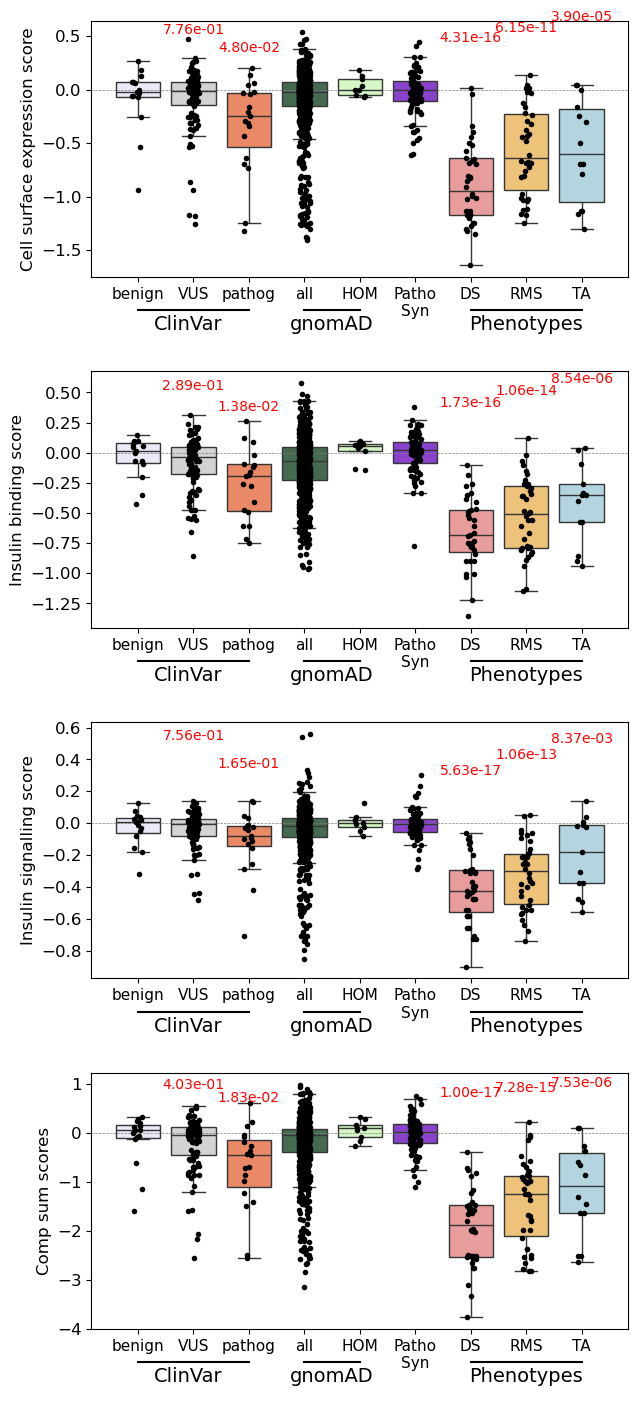

In [82]:
def annotate_dataVUS(ax, dataVUS, aa_substitutions, scores):
    for i, score in enumerate(scores):
        if score < -0.5:
            ax.annotate(aa_substitutions[i], (dataVUS[i], i), textcoords="offset points", xytext=(0,10), ha='center')

cols = ['a07a14_Bind_avg_scores', 'insBind_avg_scores', 'insSign_avg_scores', 'comp_sum_scores']

df=patient_db.copy()
df1=gnomAD_scored_hom.copy()

df1[cols] = df1[cols].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(12, 17))
plt.subplots_adjust(hspace=0.15, wspace=0.15)

gnomAD_gain = []
gnomAD_loss = []

for i, score in enumerate(cols):
    ax = plt.subplot(5, 2, i * 2 + 1)

    print(name_map[score[:-7]])

    dataClinBenign = list(ClinVarBenign_scored[score[:-7]].dropna())
    dataClinPathpo = list(ClinVarPathog_scored[score[:-7]].dropna())

    dataVUS = list(VUS_scored[score[:-7]].dropna())
    data0 = list(gnomAD_scored_all[score].dropna())
    data1 = list(df1[score].dropna())
    data_syn = list(variants_score_syns[score[:-7]].dropna())
    data2 = list(df[df['phenotype'] == 'DS'][score].dropna())
    data3 = list(df[df['phenotype'] == 'RMS'][score].dropna())
    data4 = list(df[df['phenotype'] == 'TA'][score].dropna())
    
    gnomAD_filt=gnomAD_scored_all.dropna(subset=[score])
    
    gain_cutoff=0.75
    loss_cutoff=-2.5
    
    data_ALL = [dataClinBenign,dataVUS, dataClinPathpo, data0, data1,data_syn, data2, data3, data4]

    print(len(data_ALL[0]), len(data_ALL[1]), len(data_ALL[2]), len(data_ALL[3]), len(data_ALL[4]), len(data_ALL[5]), len(data_ALL[6]), len(data_ALL[7]), len(data_ALL[8]))

    sns.boxplot(data_ALL, showfliers = False, ax=ax, palette=['#E6E6FA','lightgrey','#FF7F50','#3F704D','#D1FFBD','#8A2BE2','#F59090','#FFC966','lightblue'])
    sns.stripplot(data_ALL, color='black', size=4, ax=ax)
    
    annotate_dataVUS(ax, dataVUS, list(VUS_scored['aa_substitutions'].dropna()), dataVUS)

    plt.axhline(0, linestyle='--', c='gray', lw=0.5)

    plt.xticks([0, 1, 2, 3, 4,5,6,7,8], ['benign','VUS','pathog','all','HOM','Patho\nSyn', 'DS', 'RMS', 'TA'], size=11)
    plt.xlabel('\n ')
    plt.yticks(size=12)

    plt.ylabel(name_map[score[:-7]], size=12)
    
    comparisons = [
        ('DS', data2, data_syn), 
        ('RMS', data3, data_syn), 
        ('TA', data4, data_syn), 
        ('VUS', dataVUS, dataClinBenign), 
        ('pathog', dataClinPathpo, dataClinBenign)
    ]

    # Define custom positions for each label
    positions = {
        'DS': 6,
        'RMS': 7,
        'TA': 8,
        'VUS': 1,
        'pathog': 2
    }
    
    # Define vertical offsets to avoid overlapping
    vertical_offsets = {
        'DS': 0,
        'RMS': 0.1,
        'TA': 0.2,
        'VUS': 0,
        'pathog': -0.17
    }
    
    if score=='comp_sum_scores':
        vertical_offsets['VUS'] = 0.1
  

    for label, data, benign_set in comparisons:
        stat, p_value = mannwhitneyu(benign_set, data)
        print(f"{label} vs HOM: p-value = {p_value}")

        # Determine the position for the annotation
        max_y = max(max(benign_set), max(data))
        
        if label in ['VUS','pathog']:
            max_y = 0.52
            if score == 'comp_sum_scores':
                max_y = 0.8
        
        # Add vertical offset based on the label
        max_y += vertical_offsets.get(label, 0)
        
        if label in positions:
            position = positions[label]
            # Format p-value in scientific notation with 2 decimal places
            formatted_p = f"{p_value:.2e}"
            ax.text(position, max_y, formatted_p, ha='center', color='red', size=10)
            
    x_positions = [0.9, 3.5, 7]
    group_labels = ['ClinVar', 'gnomAD', 'Phenotypes']
    group_ranges = [(0, 2), (3, 4), (6, 8)]

    for x, label, (start, end) in zip(x_positions, group_labels, group_ranges):
        ax.plot([start, end], [-0.13, -0.13], transform=ax.get_xaxis_transform(), color='black', clip_on=False)
        ax.text(x, -0.185, label, ha='center', va='center', transform=ax.get_xaxis_transform(), fontsize=14)

    plt.subplots_adjust(bottom=0.2)

plt.tight_layout()
plt.savefig('results/figures/Fig5A.pdf', dpi=300)
plt.show()

cell surface expression score
DS vs HOM: p-value = 1.3227134274197767e-05
RMS vs HOM: p-value = 0.00024868890221895845
TA vs HOM: p-value = 0.0033901812334322834
VUS vs HOM: p-value = 0.7759054718772974
pathog vs HOM: p-value = 0.048040417282187324
122
insulin binding score
DS vs HOM: p-value = 6.463502402277913e-06
RMS vs HOM: p-value = 2.6182188804278853e-05
TA vs HOM: p-value = 0.0010639404701054558
VUS vs HOM: p-value = 0.2886892644258777
pathog vs HOM: p-value = 0.013793665923751012
276
insulin signalling score
DS vs HOM: p-value = 5.239239174666813e-06
RMS vs HOM: p-value = 5.296696354265456e-05
TA vs HOM: p-value = 0.06144026947128566
VUS vs HOM: p-value = 0.7561526307199234
pathog vs HOM: p-value = 0.16532715423132338
170
comp sum scores
DS vs HOM: p-value = 4.575795771627216e-06
RMS vs HOM: p-value = 2.322435909600517e-05
TA vs HOM: p-value = 0.0009396265049210411
VUS vs HOM: p-value = 0.4027473419632406
pathog vs HOM: p-value = 0.018347026037549133
comp min scores
DS vs HOM: 

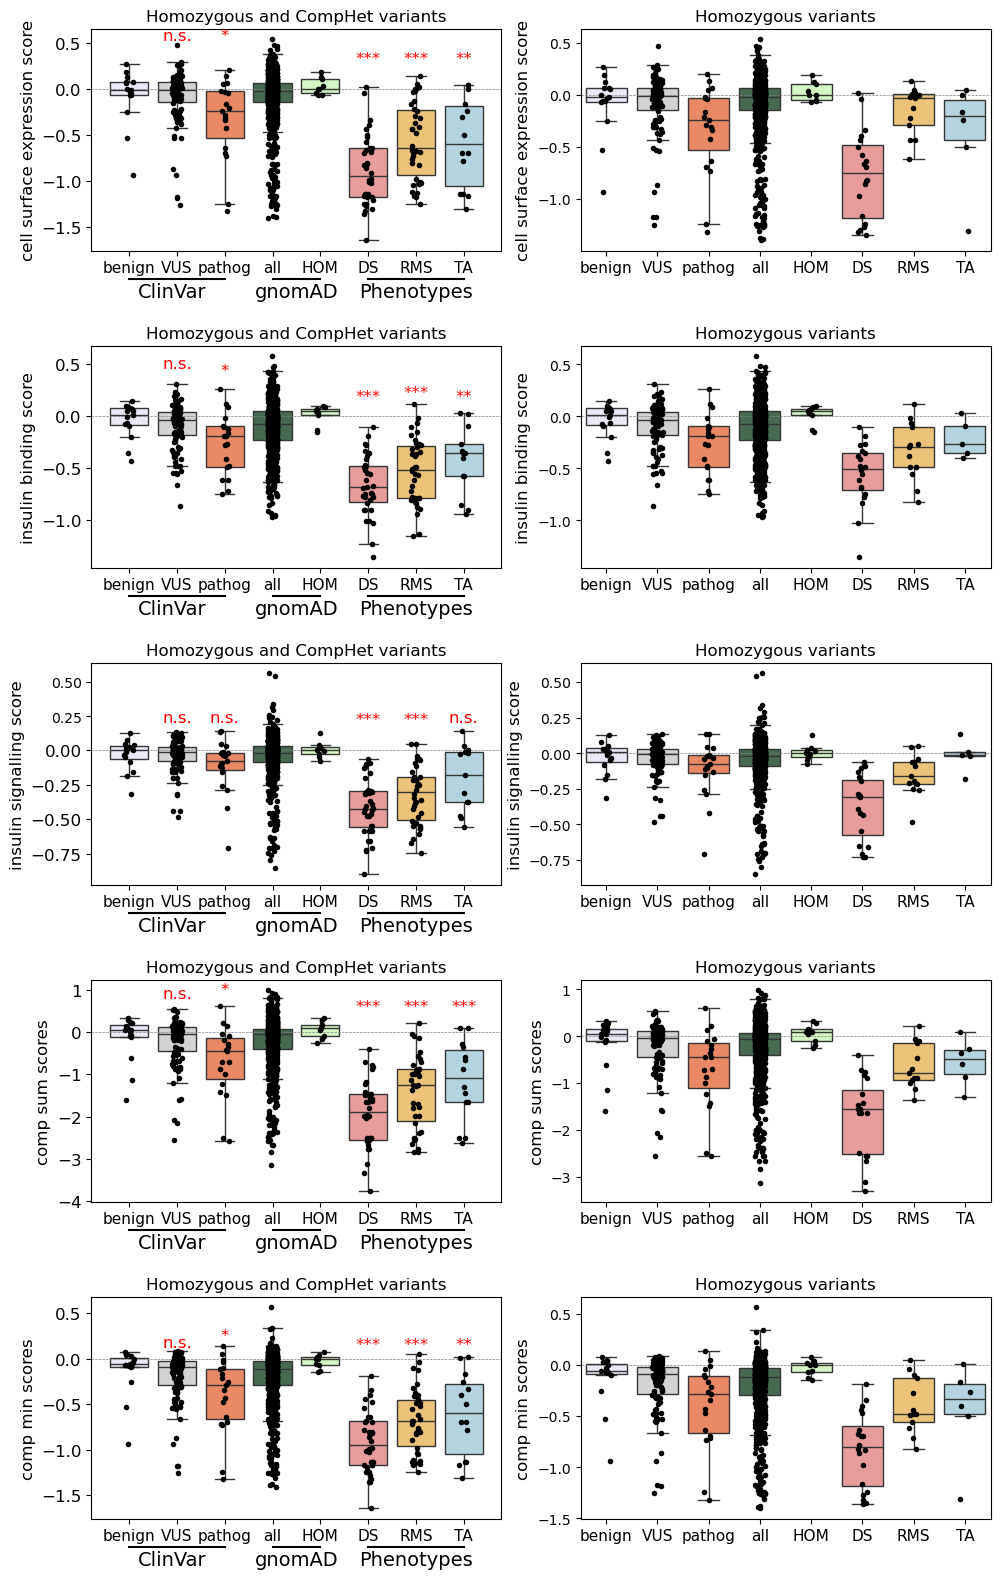

In [234]:
def annotate_dataVUS(ax, dataVUS, aa_substitutions, scores):
    for i, score in enumerate(scores):
        if score < -0.5:
            ax.annotate(aa_substitutions[i], (dataVUS[i], i), textcoords="offset points", xytext=(0,10), ha='center')


cols = ['a07a14_Bind_avg_scores', 'insBind_avg_scores', 'insSign_avg_scores', 'comp_sum_scores', 'comp_min_scores']

df=patient_db.copy()
df1=gnomAD_scored_hom.copy()

df1[cols] = df1[cols].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 16))
plt.subplots_adjust(hspace=0.15, wspace=0.15)

gnomAD_gain = []
gnomAD_loss = []

for i, score in enumerate(cols):
    ax = plt.subplot(5, 2, i * 2 + 1)
    
    print (name_map[score])

    
    dataClinBenign = list(ClinVarBenign_scored[score[:-7]].dropna())
    dataClinPathpo = list(ClinVarPathog_scored[score[:-7]].dropna())

    dataVUS = list(VUS_scored[score[:-7]].dropna())
    data0 = list(gnomAD_scored_all[score].dropna())
    data1 = list(df1[score].dropna())
    
    data2 = list(df[df['phenotype'] == 'DS'][score].dropna())
    data3 = list(df[df['phenotype'] == 'RMS'][score].dropna())
    data4 = list(df[df['phenotype'] == 'TA'][score].dropna())
    
    gnomAD_filt=gnomAD_scored_all.dropna(subset=[score])
    
    gain_cutoff=0.75
    loss_cutoff=-2.5
    
        

    data_ALL = [dataClinBenign,dataVUS, dataClinPathpo, data0, data1, data2, data3, data4]

    sns.boxplot(data_ALL, showfliers = False, ax=ax, palette=['#E6E6FA','lightgrey','#FF7F50','#3F704D','#D1FFBD','#F59090','#FFC966','lightblue'])
    sns.stripplot(data_ALL, color='black', size=4, ax=ax)
    
    annotate_dataVUS(ax, dataVUS, list(VUS_scored['aa_substitutions'].dropna()), dataVUS)

    plt.axhline(0, linestyle='--', c='gray', lw=0.5)

    plt.xticks([0, 1, 2, 3, 4,5,6,7], ['benign','VUS','pathog','all','HOM', 'DS', 'RMS', 'TA'], size=11)  # Adding x-axis labels
    plt.xlabel('\n ')
    plt.yticks(size=12)

    plt.ylabel(name_map[score], size=12)
    plt.title('Homozygous and CompHet variants', size=12)
    
    comparisons = [
    ('DS', data2, data1), 
    ('RMS', data3, data1), 
    ('TA', data4, data1), 
    ('VUS', dataVUS, dataClinBenign), 
    ('pathog', dataClinPathpo, dataClinBenign)
    ]

    # Define custom positions for each label
    positions = {
    'DS': 5,  # Last box
    'RMS': 6,  # Last box
    'TA': 7,  # Last box
    'VUS': 1,  # Second box
    'pathog': 2  # Third box
    }

    for label, data, benign_set in comparisons:
        stat, p_value = mannwhitneyu(benign_set, data)
        print(f"{label} vs HOM: p-value = {p_value}")

        # Determine the position for the annotation
        max_y = max(max(benign_set), max(data)) * 1.5  # A bit above the max value in benign_set or the compared data
        
        if score=='a07a14_Bind_avg_scores' and label in ['VUS','pathog']:
            
            max_y = 0.525  # A bit above the max value in benign_set or the compared data
            
        annotation = None

        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.005:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = 'n.s.'

        if annotation and label in positions:
            # Use the predefined position for each label
            position = positions[label]
            ax.text(position, max_y, annotation, ha='center', color='red', size=12)
            
   
            
    x_positions = [0.9, 3.5, 6]  # Mid-points for each group
    group_labels = ['ClinVar', 'gnomAD', 'Phenotypes']
    group_ranges = [(0, 2), (3, 4), (5, 7)]  # Ranges corresponding to the labels

    for x, label, (start, end) in zip(x_positions, group_labels, group_ranges):
        # Draw a line below the group
        ax.plot([start, end], [-0.13, -0.13], transform=ax.get_xaxis_transform(), color='black', clip_on=False)
    
        # Add the label below the line
        ax.text(x, -0.185, label, ha='center', va='center', transform=ax.get_xaxis_transform(), fontsize=14)

        # Add padding to make space for the annotations
    plt.subplots_adjust(bottom=0.2)



    ax = plt.subplot(5, 2, i * 2 + 2)
    
    dataClinBenign = list(ClinVarBenign_scored[score[:-7]].dropna())
    dataClinPathpo = list(ClinVarPathog_scored[score[:-7]].dropna())
    dataVUS = list(VUS_scored[score[:-7]].dropna())
    data0 = list(gnomAD_scored_all[score].dropna())
    gnomAD_filtered = gnomAD_scored_all.dropna(subset=score)
    gnomAD_aa = list(gnomAD_filtered['aa_substitutions'])
    data1 = list(df1[score].dropna())
    data2 = list(df[(df['designation'] == 'HOM') & (df['phenotype'] == 'DS')][score].dropna())
    data3 = list(df[(df['designation'] == 'HOM') & (df['phenotype'] == 'RMS')][score].dropna())
    data4 = list(df[(df['designation'] == 'HOM') & (df['phenotype'] == 'TA')][score].dropna())
    
    data_ALL = [dataClinBenign,dataVUS, dataClinPathpo, data0, data1, data2, data3, data4]

    sns.boxplot(data_ALL, showfliers = False, ax=ax, palette=['#E6E6FA','lightgrey','#FF7F50','#3F704D','#D1FFBD','#F59090','#FFC966','lightblue'])
    sns.stripplot(data_ALL, color='black', size=4, ax=ax)
    
    annotate_dataVUS(ax, dataVUS, list(VUS_scored['aa_substitutions'].dropna()), dataVUS)

    plt.axhline(0, linestyle='--', c='gray', lw=0.5)

    plt.xticks([0, 1, 2, 3, 4,5,6,7], ['benign','VUS','pathog','all','HOM', 'DS', 'RMS', 'TA'], size=11)  # Adding x-axis labels
    
    

    plt.ylabel(name_map[score], size=12)
    plt.title('Homozygous variants', size=12)
    
    if score == 'a07a14_Bind_avg_scores':
        print(sum(1 for value in data0 if value < exp_cutoff))
        
    if score == 'insBind_avg_scores':
        print(sum(1 for value in data0 if value < insBind_cutoff))
        
    if score == 'insSign_avg_scores':
        print(sum(1 for value in data0 if value < insSign_cutoff))
         
    
plt.tight_layout()
plt.savefig('results/figures/Fig5A.pdf', dpi=300)
plt.show()


In [30]:
#This script compares the insulin binding barcode of patient-specific amino acid variants to synonymous variants using barcode-level functional scores. It normalizes scores against wildtype, filters for relevant variant positions, and visualizes the differences via a boxplot to highlight functional impact.
    
    lg=pd.read_csv('results/scores/barcode_scores.csv')

syn_bc_scores = lg[(lg['variant_class'] == 'synonymous')]

wt_bc_scores = lg[lg['variant_class']=='wildtype']


all_variants = pd.Series(list(patient_db['allel_1'].unique()) + list(patient_db['allel_2'].unique())).dropna().unique()
all_variants_pos=[]
for i in all_variants:
    all_variants_pos.append(int((i[1:-1])))

pat_bc_scores = lg[lg['aa_substitutions'].isin(all_variants)]




numeric_cols = pat_bc_scores.select_dtypes(include='number').columns
pat_grouped_means = pat_bc_scores.groupby('aa_substitutions')[numeric_cols].mean()

pat_grouped_means[numeric_cols] = np.log2(pat_grouped_means[numeric_cols] / wt_bc_scores[numeric_cols].mean().values)


fg=pd.merge(variants, syn_bc_scores, on='barcode', how='right')
syn_grouped_means=fg.groupby('codon_substitutions')[numeric_cols].mean().reset_index()

syn_grouped_means[numeric_cols] = np.log2(syn_grouped_means[numeric_cols] / wt_bc_scores[numeric_cols].mean().values)
syn_grouped_means['position']= syn_grouped_means['codon_substitutions'].apply(lambda x: int(x[3:-3]))

syn_grouped_means=syn_grouped_means[syn_grouped_means['position'].isin(all_variants_pos)]  # Filter to keep only positions present in patient data


# Create a common format with a label for source
df1 = pat_grouped_means[['insulin_binding_mean']].copy()
df1['source'] = 'aa_substitutions'

df2 = syn_grouped_means[['insulin_binding_mean']].copy()
df2['source'] = 'codon_substitutions'

# Combine for plotting
combined = pd.concat([df1, df2], ignore_index=True)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='source', y='insulin_binding_mean', data=combined)
plt.title('Comparison of insulin_binding_mean')
plt.ylabel('Mean Insulin Binding')
plt.xlabel('Grouping Source')
plt.tight_layout()
plt.show()


IndentationError: unexpected indent (3158812453.py, line 3)

In [58]:
def annotate_dataVUS(ax, dataVUS, aa_substitutions, scores):
    for i, score in enumerate(scores):
        if score < -0.5:
            ax.annotate(aa_substitutions[i], (dataVUS[i], i), textcoords="offset points", xytext=(0,10), ha='center')

cols = ['a07a14_Bind_avg_scores', 'insBind_avg_scores', 'insSign_avg_scores', 'comp_sum_scores', 'comp_min_scores']

df = patient_db.copy()
df1 = gnomAD_scored_hom.copy()
df1[cols] = df1[cols].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.15, wspace=0.15)

for i, score in enumerate(cols):
    ax = plt.subplot(5, 2, i * 2 + 1)
    
    print(name_map[score])

    dataClinBenign = list(ClinVarBenign_scored[score[:-7]].dropna())
    dataClinPathpo = list(ClinVarPathog_scored[score[:-7]].dropna())
    dataVUS = list(VUS_scored[score[:-7]].dropna())
    data0 = list(gnomAD_scored_all[score].dropna())
    data1 = list(df1[score].dropna())
    
    # Insert Synonymous group here (6th group)
    dataSyn = list(SynVariants_scored[score[:-7]].dropna())  # <-- Make sure this DataFrame exists
    
    data2 = list(df[df['phenotype'] == 'DS'][score].dropna())
    data3 = list(df[df['phenotype'] == 'RMS'][score].dropna())
    data4 = list(df[df['phenotype'] == 'TA'][score].dropna())

    data_ALL = [dataClinBenign, dataVUS, dataClinPathpo, data0, data1, dataSyn, data2, data3, data4]

    sns.boxplot(data_ALL, showfliers=False, ax=ax,
                palette=['#E6E6FA','lightgrey','#FF7F50','#3F704D','#D1FFBD','grey','#F59090','#FFC966','lightblue'])
    sns.stripplot(data_ALL, color='black', size=4, ax=ax)

    annotate_dataVUS(ax, dataVUS, list(VUS_scored['aa_substitutions'].dropna()), dataVUS)

    plt.axhline(0, linestyle='--', c='gray', lw=0.5)

    plt.xticks(range(9), ['benign','VUS','pathog','all','HOM','syn','DS','RMS','TA'], size=11)
    plt.xlabel('\n ')
    plt.yticks(size=12)

    plt.ylabel(name_map[score], size=12)
    plt.title('Homozygous and CompHet variants', size=12)

    comparisons = [
        ('DS', data2, data1), 
        ('RMS', data3, data1), 
        ('TA', data4, data1), 
        ('VUS', dataVUS, dataClinBenign), 
        ('pathog', dataClinPathpo, dataClinBenign)
    ]

    positions = {'DS': 6, 'RMS': 7, 'TA': 8, 'VUS': 1, 'pathog': 2}

    for label, data, benign_set in comparisons:
        stat, p_value = mannwhitneyu(benign_set, data)
        print(f"{label} vs HOM: p-value = {p_value}")

        max_y = max(max(benign_set), max(data)) * 1.5
        if score == 'a07a14_Bind_avg_scores' and label in ['VUS','pathog']:
            max_y = 0.525

        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.005:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = 'n.s.'

        if annotation and label in positions:
            position = positions[label]
            ax.text(position, max_y, annotation, ha='center', color='red', size=12)

    x_positions = [1.0, 3.5, 6.5]  # Mid-points for groups
    group_labels = ['ClinVar', 'gnomAD', 'Phenotypes']
    group_ranges = [(0, 2), (3, 5), (6, 8)]

    for x, label, (start, end) in zip(x_positions, group_labels, group_ranges):
        ax.plot([start, end], [-0.13, -0.13], transform=ax.get_xaxis_transform(), color='black', clip_on=False)
        ax.text(x, -0.185, label, ha='center', va='center', transform=ax.get_xaxis_transform(), fontsize=14)

    plt.subplots_adjust(bottom=0.2)

    ax = plt.subplot(5, 2, i * 2 + 2)

    dataClinBenign = list(ClinVarBenign_scored[score[:-7]].dropna())
    dataClinPathpo = list(ClinVarPathog_scored[score[:-7]].dropna())
    dataVUS = list(VUS_scored[score[:-7]].dropna())
    data0 = list(gnomAD_scored_all[score].dropna())

    data1 = list(df1[score].dropna())
    dataSyn = list(SynVariants_scored[score[:-7]].dropna())  # Same Synonymous set
    data2 = list(df[(df['designation'] == 'HOM') & (df['phenotype'] == 'DS')][score].dropna())
    data3 = list(df[(df['designation'] == 'HOM') & (df['phenotype'] == 'RMS')][score].dropna())
    data4 = list(df[(df['designation'] == 'HOM') & (df['phenotype'] == 'TA')][score].dropna())

    data_ALL = [dataClinBenign, dataVUS, dataClinPathpo, data0, data1, dataSyn, data2, data3, data4]

    sns.boxplot(data_ALL, showfliers=False, ax=ax,
                palette=['#E6E6FA','lightgrey','#FF7F50','#3F704D','#D1FFBD','grey','#F59090','#FFC966','lightblue'])
    sns.stripplot(data_ALL, color='black', size=4, ax=ax)

    annotate_dataVUS(ax, dataVUS, list(VUS_scored['aa_substitutions'].dropna()), dataVUS)

    plt.axhline(0, linestyle='--', c='gray', lw=0.5)
    plt.xticks(range(9), ['benign','VUS','pathog','all','HOM','syn','DS','RMS','TA'], size=11)
    plt.ylabel(name_map[score], size=12)
    plt.title('Homozygous variants', size=12)

    if score == 'a07a14_Bind_avg_scores':
        print(sum(1 for value in data0 if value < exp_cutoff))

    if score == 'insBind_avg_scores':
        print(sum(1 for value in data0 if value < insBind_cutoff))

    if score == 'insSign_avg_scores':
        print(sum(1 for value in data0 if value < insSign_cutoff))

plt.tight_layout()
plt.show()

KeyError: 'a07a14_Bind_avg_scores'

In [ ]:
x='hty198uit'
x[3:-3]

'198'

In [ ]:
syn_grouped_means['position']= syn_grouped_means['codon_substitutions'].apply(lambda x: int(x[3:-3]))
syn_grouped_means

,codon_substitutions,insulin_binding_rep1,mAb83-7_binding_rep1,mAb83-14_binding_rep1,insulin_signalling_rep1,mAb83-7_signalling_rep1,mAb83-14_signalling_rep1,insulin_binding_rep2,mAb83-7_binding_rep2,mAb83-14_binding_rep2,...,mAb83-7_signalling_rep3,insulin_binding_mean,mAb83-7_binding_mean,mAb83-14_binding_mean,insulin_signalling_mean,mAb83-7_signalling_mean,mAb83-14_signalling_mean,mAb83-7_mAb83-14_binding_mean,mAb83-7_mAb83-14_signalling_mean,position
0,AAA176AAG,-0.075632,-0.318080,-0.447191,0.092718,-0.001163,-0.044787,-0.160058,-0.491339,-0.096697,...,0.266591,-0.116407,-0.401290,-0.256044,-0.099864,0.179001,-0.164762,-0.321933,0.019992,176
1,AAA217AAG,NaN,NaN,NaN,0.128743,NaN,-0.859318,0.223925,-0.192718,NaN,...,-0.365692,0.229954,-0.164114,NaN,0.123494,-0.130222,-0.177780,-0.158034,-0.191036,217
2,AAA292AAG,0.231672,0.215568,0.119797,0.038876,0.078060,-0.028617,0.168701,0.305914,0.251815,...,-0.066846,0.201388,0.264681,0.191956,-0.089111,-0.004669,-0.042196,0.233768,-0.021134,292
3,AAA396AAG,-0.097818,-0.553755,-0.227456,-0.097822,-0.223954,-0.396317,0.195786,-0.760658,-0.597823,...,-0.044955,0.057923,-0.652988,-0.397630,-0.183832,-0.130630,-0.306296,-0.514802,-0.213396,396
4,AAA443AAG,0.090390,0.011575,0.221261,-0.038476,-0.068266,-0.044322,0.203493,-0.280459,0.107222,...,0.013760,0.149217,-0.251981,0.104066,0.029414,-0.081296,0.082690,-0.157152,0.004886,443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,TTT599TTC,NaN,-0.257764,0.096469,0.147805,0.374400,0.408972,0.050462,0.065456,-0.330998,...,0.166310,0.056491,-0.081769,-0.098499,0.150444,0.285922,0.310444,-0.085140,0.301856,599
1108,TTT728TTC,0.049898,-0.121366,-0.075199,0.030296,0.081325,0.222757,0.023509,-0.102155,-0.001954,...,-0.004863,0.037686,-0.109147,-0.033646,0.022343,0.106890,0.145597,-0.049251,0.115495,728
1109,TTT732TTC,-0.040295,-0.170254,-0.157594,-0.110265,0.044986,-0.256153,-0.008948,-0.352251,-0.371307,...,-0.226278,-0.024913,-0.342148,-0.340279,-0.146439,-0.200450,-0.140135,-0.314694,-0.215934,732
1110,TTT798TTC,-0.145705,-0.035123,-0.195969,-0.035639,0.063501,0.093189,-0.136909,-0.124708,-0.043337,...,0.034776,-0.140154,-0.039540,-0.064587,-0.010227,0.063842,0.001178,-0.055016,0.051442,798


In [ ]:
syn_grouped_means

,codon_substitutions,insulin_binding_rep1,mAb83-7_binding_rep1,mAb83-14_binding_rep1,insulin_signalling_rep1,mAb83-7_signalling_rep1,mAb83-14_signalling_rep1,insulin_binding_rep2,mAb83-7_binding_rep2,mAb83-14_binding_rep2,...,mAb83-14_signalling_rep3,mAb83-7_signalling_rep3,insulin_binding_mean,mAb83-7_binding_mean,mAb83-14_binding_mean,insulin_signalling_mean,mAb83-7_signalling_mean,mAb83-14_signalling_mean,mAb83-7_mAb83-14_binding_mean,mAb83-7_mAb83-14_signalling_mean
0,AAA176AAG,-0.075632,-0.318080,-0.447191,0.092718,-0.001163,-0.044787,-0.160058,-0.491339,-0.096697,...,-0.111939,0.266591,-0.116407,-0.401290,-0.256044,-0.099864,0.179001,-0.164762,-0.321933,0.019992
1,AAA217AAG,NaN,NaN,NaN,0.128743,NaN,-0.859318,0.223925,-0.192718,NaN,...,-0.137732,-0.365692,0.229954,-0.164114,NaN,0.123494,-0.130222,-0.177780,-0.158034,-0.191036
2,AAA292AAG,0.231672,0.215568,0.119797,0.038876,0.078060,-0.028617,0.168701,0.305914,0.251815,...,-0.142010,-0.066846,0.201388,0.264681,0.191956,-0.089111,-0.004669,-0.042196,0.233768,-0.021134
3,AAA396AAG,-0.097818,-0.553755,-0.227456,-0.097822,-0.223954,-0.396317,0.195786,-0.760658,-0.597823,...,-0.332405,-0.044955,0.057923,-0.652988,-0.397630,-0.183832,-0.130630,-0.306296,-0.514802,-0.213396
4,AAA443AAG,0.090390,0.011575,0.221261,-0.038476,-0.068266,-0.044322,0.203493,-0.280459,0.107222,...,0.185404,0.013760,0.149217,-0.251981,0.104066,0.029414,-0.081296,0.082690,-0.157152,0.004886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,TTT599TTC,NaN,-0.257764,0.096469,0.147805,0.374400,0.408972,0.050462,0.065456,-0.330998,...,0.096153,0.166310,0.056491,-0.081769,-0.098499,0.150444,0.285922,0.310444,-0.085140,0.301856
1187,TTT728TTC,0.049898,-0.121366,-0.075199,0.030296,0.081325,0.222757,0.023509,-0.102155,-0.001954,...,-0.243769,-0.004863,0.037686,-0.109147,-0.033646,0.022343,0.106890,0.145597,-0.049251,0.115495
1188,TTT732TTC,-0.040295,-0.170254,-0.157594,-0.110265,0.044986,-0.256153,-0.008948,-0.352251,-0.371307,...,0.077339,-0.226278,-0.024913,-0.342148,-0.340279,-0.146439,-0.200450,-0.140135,-0.314694,-0.215934
1189,TTT798TTC,-0.145705,-0.035123,-0.195969,-0.035639,0.063501,0.093189,-0.136909,-0.124708,-0.043337,...,-0.059893,0.034776,-0.140154,-0.039540,-0.064587,-0.010227,0.063842,0.001178,-0.055016,0.051442


In [ ]:
for i in syn_grouped_means['codon_substitutions']:
    print(i)
    
    print(int(i[3:-3]))

AAA176AAG
176
AAA217AAG
217
AAA292AAG
292
AAA396AAG
396
AAA443AAG
443
AAA452AAG
452
AAA460AAG
460
AAA501AAG
501
AAA535AAG
535
AAA571AAG
571
AAA643AAG
643
AAA676AAG
676
AAA67AAG
67
AAA745AAG
745
AAA760AAG
760
AAA80AAG
80
AAC135AAT
135
AAC175AAT
175
AAC202AAT
202
AAC242AAT
242
AAC257AAT
257
AAC282AAT
282
AAC309AAT
309
AAC370AAT
370
AAC458AAT
458
AAC554AAT
554
AAC621AAT
621
AAC633AAT
633
AAC651AAT
651
AAC826AAT
826
AAC864AAT
864
AAC933AAT
933
AAG129AAA
129
AAG129AAA AAA535AAG


ValueError: invalid literal for int() with base 10: '129AAA AAA535'

In [ ]:
pat_bc_scores

,barcode,aa_substitutions,insulin_binding_rep1,mAb83-7_binding_rep1,mAb83-14_binding_rep1,insulin_signalling_rep1,mAb83-7_signalling_rep1,mAb83-14_signalling_rep1,insulin_binding_rep2,mAb83-7_binding_rep2,...,insulin_binding_mean,mAb83-7_binding_mean,mAb83-14_binding_mean,insulin_signalling_mean,mAb83-7_signalling_mean,mAb83-14_signalling_mean,position,mAb83-7_mAb83-14_binding_mean,mAb83-7_mAb83-14_signalling_mean,variant_class
468,AAAACAGCTTCGCAAGTTCCCACGGCCGTA,H28Q,0.556731,0.583522,0.646378,0.598291,0.647358,0.581501,0.688763,0.551368,...,0.622747,0.567445,0.628188,0.587143,0.594624,0.586773,28,0.597817,0.590699,missense
1229,AAACAAAGATAGACGAGAATCGCACGATGA,K487E,0.747902,0.696612,0.697314,0.723088,0.775581,0.879142,0.692446,0.722613,...,0.720174,0.709613,0.645787,0.701735,0.706501,0.739602,487,0.677700,0.723051,missense
1338,AAACAGCACCTAGATAGCACGAGTTAAAGA,V657F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.602312,657,NaN,0.602312,missense
2159,AAAGCGATAAGAGAAACAGTAAGTATGGTA,P874L,0.445250,NaN,0.479202,0.669173,0.661329,0.676120,0.509331,0.489325,...,0.477291,0.489325,0.490156,0.684601,0.557860,0.575547,874,0.489879,0.566703,missense
2378,AAAGGTAGCAATTTTTGTAAGTGCAGCTGG,R41W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.425664,NaN,NaN,41,NaN,NaN,missense
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96397,TTGGGCCGAGTCGAGGAGCCTTCAGAGACG,Y818C,0.504815,0.355957,0.436754,0.578951,0.508108,0.688267,0.587869,0.279094,...,0.546342,0.317526,0.366440,0.577020,0.509339,0.505638,818,0.341983,0.507119,missense
97021,TTTAACAAATTGAGCCGACATAGTATCCAA,L822P,0.409399,0.540840,0.470379,0.853766,0.795186,0.637124,0.741614,0.597220,...,0.575507,0.569030,0.512725,0.775460,0.726770,0.697442,822,0.540878,0.712106,missense
97170,TTTACAGTAATAAAGGGGTAAGTCGGGATA,S98R,0.500378,0.619978,0.574827,0.595639,0.596382,0.580509,0.528778,0.580291,...,0.514578,0.600134,0.620223,0.627933,0.611054,0.609980,98,0.610179,0.610517,missense
97805,TTTGAATTGCGCATGACGTGTCTGGAATTT,F275C,0.420630,0.413403,0.482863,0.462729,0.616233,0.548253,0.444395,0.396570,...,0.432513,0.404987,0.462434,0.495545,0.543877,0.567207,275,0.433710,0.555542,missense


In [ ]:
pat_bc_scores.groupby('aa_substitutions')[numeric_cols].mean()

,insulin_binding_rep1,mAb83-7_binding_rep1,mAb83-14_binding_rep1,insulin_signalling_rep1,mAb83-7_signalling_rep1,mAb83-14_signalling_rep1,insulin_binding_rep2,mAb83-7_binding_rep2,mAb83-14_binding_rep2,mAb83-7_signalling_rep2,...,mAb83-14_signalling_rep3,mAb83-7_signalling_rep3,insulin_binding_mean,mAb83-7_binding_mean,mAb83-14_binding_mean,insulin_signalling_mean,mAb83-7_signalling_mean,mAb83-14_signalling_mean,mAb83-7_mAb83-14_binding_mean,mAb83-7_mAb83-14_signalling_mean
aa_substitutions,,,,,,,,,,,,,,,,,,,,,
A119T,0.433235,0.518656,0.560587,0.549925,0.619950,0.670771,0.495447,0.580883,0.545961,0.593385,...,0.647659,0.645954,0.481460,0.555005,0.556731,0.584967,0.624528,0.619628,0.558533,0.614939
A119V,0.440892,0.534340,0.546159,0.610953,0.581285,0.608401,0.501951,0.518353,0.521999,0.552265,...,0.563193,0.518056,0.471421,0.526347,0.534079,0.611938,0.550549,0.558491,0.530213,0.553264
C186F,0.552771,0.713034,0.675686,0.385870,0.613969,0.554470,0.470401,0.618269,0.599256,0.621053,...,0.562889,0.647146,0.480616,0.679621,0.637471,0.414191,0.635101,0.556077,0.646263,0.623254
C243Y,0.344501,0.255938,0.282664,0.425619,0.393393,0.364662,0.376239,0.281325,0.285122,0.434669,...,0.306535,0.390345,0.345561,0.263411,0.280480,0.446102,0.395653,0.426073,0.272632,0.409170
C264Y,NaN,0.283048,0.275914,0.352300,0.393075,0.542429,0.471613,0.270569,0.277120,NaN,...,0.368517,0.329737,0.471613,0.276808,0.276517,0.465177,0.367778,0.455473,0.276663,0.407599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W210C,0.533572,0.690694,0.667705,0.406769,0.578373,0.556201,0.533202,0.609407,0.665497,0.588956,...,0.576900,0.537018,0.533387,0.650051,0.666601,0.457820,0.568116,0.569776,0.658326,0.568946
W439S,0.444913,0.406016,0.440168,0.570211,0.504720,0.562929,0.542575,0.359149,0.424214,0.477789,...,0.515649,0.510046,0.491612,0.382583,0.432191,0.601736,0.482504,0.563076,0.417494,0.495299
W516R,0.319644,0.262304,0.254809,0.301159,0.268623,NaN,NaN,0.255138,NaN,NaN,...,NaN,NaN,0.319644,0.257437,0.254809,0.384993,0.268623,0.341210,0.256561,0.304916


In [ ]:
pat_bc_scores['insulin_binding_mean']

468      0.622747
1229     0.720174
1338          NaN
2159     0.477291
2378          NaN
           ...   
96397    0.546342
97021    0.575507
97170    0.514578
97805    0.432513
97815    0.566544
Name: insulin_binding_mean, Length: 357, dtype: float64

### gnomAD variants Venn diagram comparing results for categorical loss of expression, insulin binding, and signaling determined by applying cut-offs from supp figs7A-C

122
276
170


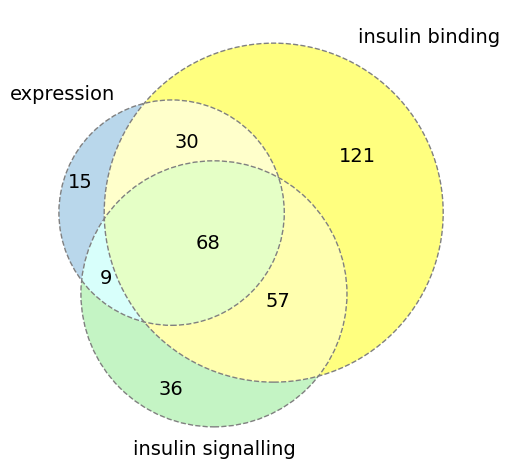

In [ ]:
mdf=gnomAD_scored_all.copy()
mdf = mdf.dropna(subset='a07a14_Bind_avg_scores')
mdf = mdf[mdf['a07a14_Bind_avg_scores'] < exp_cutoff]
gnomAD_aa_exp = list(mdf['aa_substitutions'])

mdf=gnomAD_scored_all.copy()
mdf = mdf.dropna(subset='insBind_avg_scores')
mdf = mdf[mdf['insBind_avg_scores'] < insBind_cutoff]
gnomAD_aa_insBind = list(mdf['aa_substitutions'])

mdf=gnomAD_scored_all.copy()
mdf = mdf.dropna(subset='insSign_avg_scores')
mdf = mdf[mdf['insSign_avg_scores'] < insSign_cutoff]
gnomAD_aa_insSign = list(mdf['aa_substitutions'])

gnomAD_aa_exp=set(gnomAD_aa_exp)
gnomAD_aa_insBind=set(gnomAD_aa_insBind)
gnomAD_aa_insSign=set(gnomAD_aa_insSign)

print (len(gnomAD_aa_exp))
print (len(gnomAD_aa_insBind))
print (len(gnomAD_aa_insSign))

# Create the Venn diagram for Loss
out=venn3([gnomAD_aa_exp, gnomAD_aa_insBind, gnomAD_aa_insSign],
      ('expression', 'insulin binding', 'insulin signalling'),
     set_colors=('#74B1D9','#FFFF00','#8AEA8A'),
         alpha=0.5)

venn3_circles(subsets = [gnomAD_aa_exp, gnomAD_aa_insBind, gnomAD_aa_insSign]
              , linestyle='dashed', linewidth=1, color="grey")

for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(14)
    
# Adjust layout
plt.tight_layout()

plt.tight_layout()
plt.savefig('results/figures/SuppFig8F.pdf', dpi=300)
plt.show()

### ClinVar VUS variants Venn diagram comparing results for categorical loss of expression, insulin binding, and signaling 

102
18
21
88
6
19
14
29
14


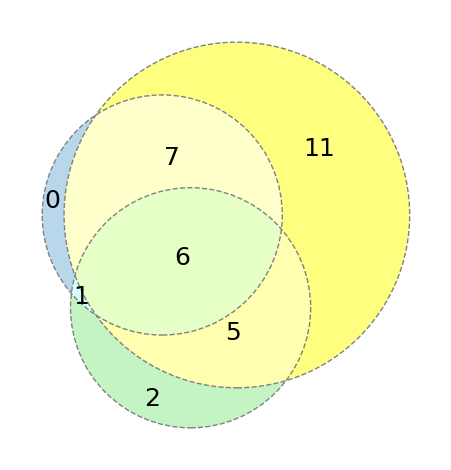

{'V840I', 'C235F', 'E57K', 'G365R', 'C243Y', 'R729G'}


In [ ]:
#here reading ClinVar data again but this time will filter conflicting VUS from paathogenic and benign datasets

ClinVar_VUS = parse_ClinVarMiner('input_files/ClinVarMiner_VUS.csv')
ClinVarBenign = parse_ClinVarMiner('input_files/ClinVarMiner_benignORLikBenign.csv')
ClinVarPathog = parse_ClinVarMiner('input_files/clinvar_pathogenic_AND_LkelyPathogenic.csv') #check this if, included likley pathogenic?????????????

ClinVar_VUS = ClinVar_VUS.loc[~ClinVar_VUS['aa_substitutions'].str.endswith('*')]
ClinVarBenign = ClinVarBenign.loc[~ClinVarBenign['aa_substitutions'].str.endswith('*')]
ClinVarPathog = ClinVarPathog.loc[~ClinVarPathog['aa_substitutions'].str.endswith('*')]

ClinVar_VUS.drop_duplicates(subset=['aa_substitutions'], inplace=True)
ClinVarBenign.drop_duplicates(subset=['aa_substitutions'], inplace=True)
ClinVarPathog.drop_duplicates(subset=['aa_substitutions'], inplace=True)

print (len(ClinVar_VUS))
print (len(ClinVarBenign))
print (len(ClinVarPathog))

ClinVarBenign_conflicting = (list(ClinVarBenign[ClinVarBenign['aa_substitutions'].isin(ClinVar_VUS['aa_substitutions'])]['aa_substitutions']))
ClinVarPathog_conflicting = (list(ClinVarPathog[ClinVarPathog['aa_substitutions'].isin(ClinVar_VUS['aa_substitutions'])]['aa_substitutions']))
all_conflicting_variants=ClinVarBenign_conflicting+ClinVarPathog_conflicting

ClinVar_VUS=ClinVar_VUS[~ClinVar_VUS['aa_substitutions'].isin(all_conflicting_variants)]
ClinVarBenign=ClinVarBenign[~ClinVarBenign['aa_substitutions'].isin(all_conflicting_variants)]
ClinVarPathog=ClinVarPathog[~ClinVarPathog['aa_substitutions'].isin(all_conflicting_variants)]

print (len(ClinVar_VUS))
print (len(ClinVarBenign))
print (len(ClinVarPathog))

VUS_scored=pd.merge(ClinVar_VUS,var_score, on='aa_substitutions')
VUS_scored.drop_duplicates(subset=['aa_substitutions'], inplace=True)
VUS_scored['comp_sum']=VUS_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].sum(axis=1)
VUS_scored['comp_min']=VUS_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].min(axis=1) 

ClinVarBenign_scored=pd.merge(ClinVarBenign,var_score, on='aa_substitutions')
ClinVarBenign_scored.drop_duplicates(subset=['aa_substitutions'], inplace=True)

ClinVarBenign_scored['comp_sum']=ClinVarBenign_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].sum(axis=1)
ClinVarBenign_scored['comp_min']=ClinVarBenign_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].min(axis=1)

ClinVarPathog_scored=pd.merge(ClinVarPathog,var_score, on='aa_substitutions')
ClinVarPathog_scored.drop_duplicates(subset=['aa_substitutions'], inplace=True)
ClinVarPathog_scored['comp_sum']=ClinVarPathog_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].sum(axis=1)
ClinVarPathog_scored['comp_min']=ClinVarPathog_scored[['insBind_avg','insSign_avg', 'a07a14_Bind_avg']].min(axis=1)



mdf=VUS_scored.copy()
mdf = mdf.dropna(subset='a07a14_Bind_avg')
mdf = mdf[mdf['a07a14_Bind_avg'] < exp_cutoff]
gnomAD_aa_exp = list(mdf['aa_substitutions'])

mdf=VUS_scored.copy()
mdf = mdf.dropna(subset='insBind_avg')
mdf = mdf[mdf['insBind_avg'] < insBind_cutoff]
gnomAD_aa_insBind = list(mdf['aa_substitutions'])

mdf=VUS_scored.copy()
mdf = mdf.dropna(subset='insSign_avg')
mdf = mdf[mdf['insSign_avg'] < insSign_cutoff]
gnomAD_aa_insSign = list(mdf['aa_substitutions'])

gnomAD_aa_exp=set(gnomAD_aa_exp)
gnomAD_aa_insBind=set(gnomAD_aa_insBind)
gnomAD_aa_insSign=set(gnomAD_aa_insSign)

print (len(gnomAD_aa_exp))
print (len(gnomAD_aa_insBind))
print (len(gnomAD_aa_insSign))


# Create the Venn diagram for Loss
out=venn3([gnomAD_aa_exp, gnomAD_aa_insBind, gnomAD_aa_insSign],
      ('', '', ''),
     set_colors=('#74B1D9','#FFFF00','#8AEA8A'),
         alpha=0.5)

venn3_circles(subsets = [gnomAD_aa_exp, gnomAD_aa_insBind, gnomAD_aa_insSign]
              , linestyle='dashed', linewidth=1, color="grey")

for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
    
# Adjust layout
plt.tight_layout()

plt.tight_layout()
plt.savefig('results/figures/SuppFig8A.pdf', dpi=300, transparent=True)
plt.show()

print(gnomAD_aa_exp.intersection(gnomAD_aa_insBind, gnomAD_aa_insSign))



In [ ]:

unsupervised = ['LIST-S2','ESM-1v','EVE','DeepSequence','MutationAssessor','PROVEAN','SIFT','SIFT4G','phyloP','SiPhy',
               'fitCons','phastCons','BLOSUM62','GERP++','Grantham','LRT','GenoCanyon','EVmutation_epistatic','EVmutation_independent',
               'VESPAl','mutationTCN','LASSIE','EVmutation_epistatic','EVmutation_independent',
               'ESM-1b','DeMaSk','iGEMME']

sel_columns=['insBindR1', 'insBindR2', 'a07BindR1',
  'a07BindR2', 'a14BindR1','a14BindR2', 'insSignR1', 
  'insSignR2', 'insSignR3', 'insSignR4',
  'insSignR5','a07SignR1', 'a07SignR2',
  'a07SignR3','a14SignR1','a14SignR2','a14SignR3']



gnomAD = parse_gnomAD('input_files/INSR_gnomAD.csv')


gnomAD = gnomAD[~gnomAD['variant'].isin(df.index)].drop_duplicates(subset='variant')
gnomAD.set_index('variant', inplace=True)

dms_data = var_score[score_cols].copy()
dms_data = dms_data[~dms_data['aa_substitutions'].isin(['wildtype', 'synonymous', 'stop'])]
dms_data['position'] = dms_data['aa_substitutions'].apply(lambda x: int(x[1:-1]))

#merge dms data with gnomAD data ############
dms_data.set_index('aa_substitutions', inplace=True, drop=True)
gnomAD_scored_all=pd.merge(gnomAD, dms_data, how='left', left_index=True, right_index=True)


#merge dms data with VEP data  ##################
invert = ['BLOSUM62','SIFT','SIFT4G','LRT','FATHMM','PROVEAN','Envision','mutationTCN',
'ESM-1v','DeepSequence','fitCons', 'EVmutation_epistatic','EVmutation_independent',
         'COSMIS','ESM-1b','DeMaSk','MOIpred_benign','ESCOTT','iGEMME',
          'a07a14_Bind_avg','insSign_avg','insBind_avg',
          'comp_sum_scores','comp_min_scores']

dms_data_modified=dms_data.copy()
dms_data_modified_filtered = dms_data_modified


dms_data_modified_filtered['comp_sum_scores']=dms_data_modified_filtered[['insBind_avg','insSign_avg','a07a14_Bind_avg']].sum(axis=1)
dms_data_modified_filtered['comp_min_scores']=dms_data_modified_filtered[['insBind_avg','insSign_avg','a07a14_Bind_avg']].min(axis=1)

dms_data_modified_filtered=dms_data_modified_filtered[(dms_data_modified_filtered['position']>=28) & (dms_data_modified_filtered['position']<=955)]
dms_data_modified_filtered=dms_data_modified_filtered.drop('position', axis=1)

dms_vep=pd.merge(dms_data_modified_filtered, VEP_data, left_index=True, right_index=True)
dms_vep=dms_vep.drop('aa_substitutions', axis=1)


for col in dms_vep.columns:
    if col in invert:
        dms_vep[col] = min(dms_vep[col]) - dms_vep[col] + max(dms_vep[col])
      

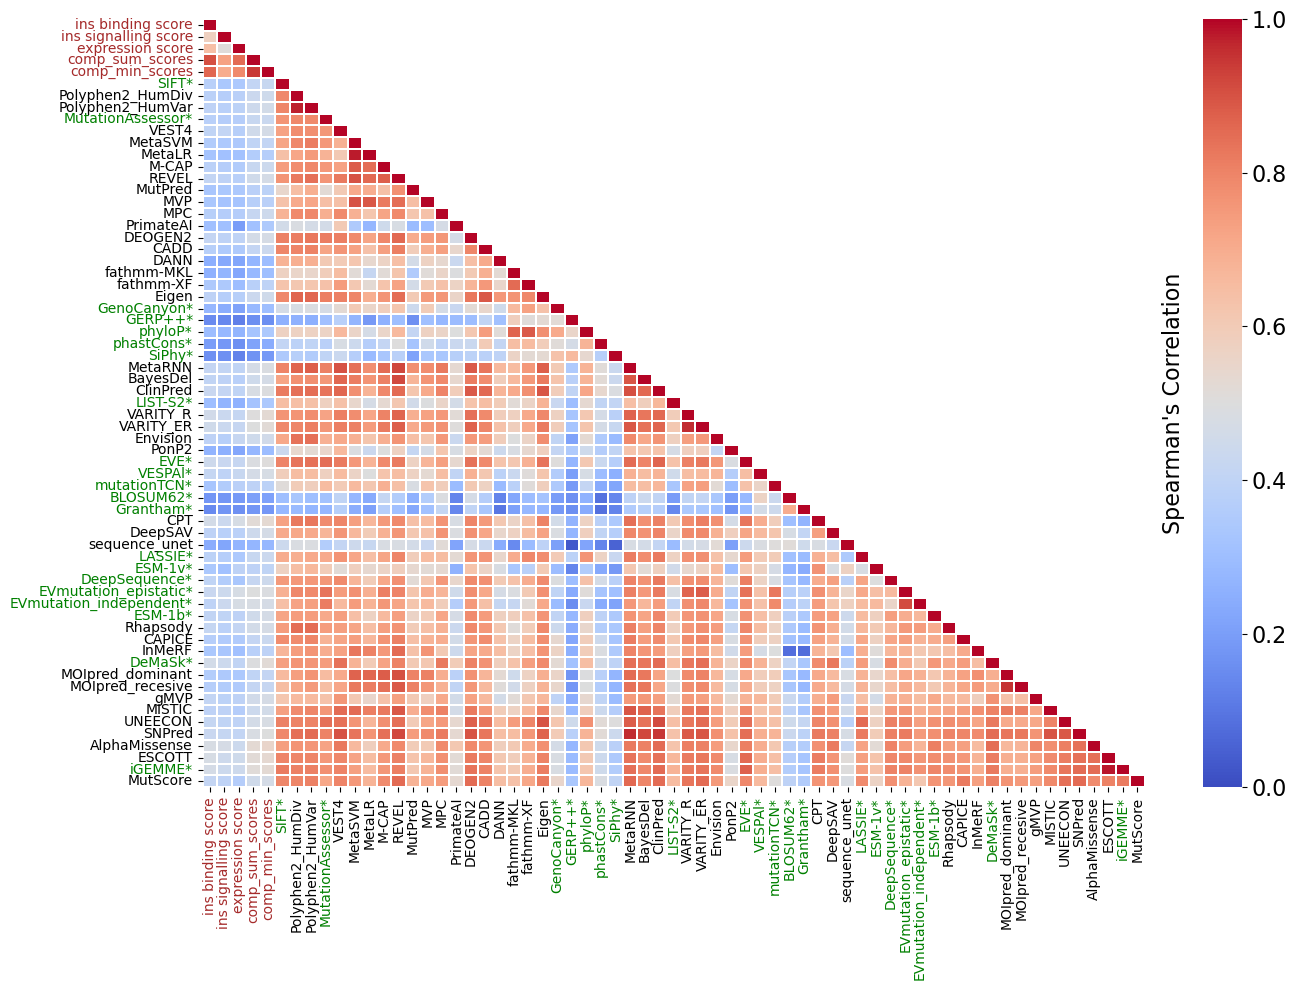

In [ ]:
# Select the columns
selected_columns = dms_vep.columns
#these predictors have mostly zero scove for INSR variants or have negative correlation for all the others like MutationTaster and COSMIS
toDrop=['FATHMM','LINSIGHT','PROVEAN','SIFT4G','LRT','MOIpred_benign','MutationTaster','COSMIS' ]
for col in toDrop:
    if col in dms_vep.columns:
        dms_vep=dms_vep.drop(col, axis=1)

fsize = 14


df = pd.DataFrame(index=dms_vep.columns, columns=dms_vep.columns)

# Loop through all pairs of columns
for i, column1 in enumerate(dms_vep.columns):
    for j, column2 in enumerate(dms_vep.columns):
                
        # Select the columns and drop NaN values
        df_temp = dms_vep[[column1, column2]].dropna()
         
        #print (str(len(df_temp))+ ' ' + column1 + ' ' +column2)
        #if len (df_temp) < 5000:
            #continue
        df_temp.reset_index(drop=True, inplace=True)

        # Flatten the columns before calculating Pearson correlation coefficient
        correlation, _ = spearmanr(df_temp[column1].values.flatten(), df_temp[column2].values.flatten())

        # Store the correlation in the DataFrame
        df.iloc[i, j] = correlation

# Convert the correlation values to numeric
df = df.apply(pd.to_numeric)



#df.sort_values('comp_sum_scores', ascending=False ,inplace=True)



plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(df, dtype=bool), k=1)
heatmap = sns.heatmap(df, annot=False, cmap='coolwarm', fmt=".2f",
                      linewidths=.1, mask=mask, vmin=0, vmax=1,
                      yticklabels=True, xticklabels=True)

plt.xticks(size=10)
plt.yticks(size=10)

# Get the current tick labels
y_labels = [label.get_text() for label in heatmap.yaxis.get_ticklabels()]
x_labels = [label.get_text() for label in heatmap.xaxis.get_ticklabels()]

# Modify the labels
new_y_labels = []
for text in y_labels:
    if text == 'a07a14_Bind_avg':
        new_text = 'expression score'
    elif text == 'insSign_avg':
        new_text = 'ins signalling score'
    elif text == 'insBind_avg':
        new_text = 'ins binding score'
    elif text in unsupervised:
        new_text = text + '*'
    else:
        new_text = text
    new_y_labels.append(new_text)

new_x_labels = []
for text in x_labels:
    if text == 'a07a14_Bind_avg':
        new_text = 'expression score'
    elif text == 'insSign_avg':
        new_text = 'ins signalling score'
    elif text == 'insBind_avg':
        new_text = 'ins binding score'
    elif text in unsupervised:
        new_text = text + '*'
    else:
        new_text = text
    new_x_labels.append(new_text)

# Set the new labels
heatmap.set_yticklabels(new_y_labels)
heatmap.set_xticklabels(new_x_labels)

# Now apply the coloring
for label in heatmap.yaxis.get_ticklabels():
    text = label.get_text()
    if text.endswith('*'):
        label.set_color('green')
    elif text in ['expression score', 'ins signalling score', 'ins binding score',
                 'comp_sum_scores', 'comp_min_scores']:
        label.set_color('brown')

for label in heatmap.xaxis.get_ticklabels():
    text = label.get_text()
    if text.endswith('*'):
        label.set_color('green')
    elif text in ['expression score', 'ins signalling score', 'ins binding score',
                 'comp_sum_scores', 'comp_min_scores']:
        label.set_color('brown')


# Adjust the position of the colorbar label
cbar = heatmap.collections[0].colorbar
cbar.set_label("Spearman's Correlation", labelpad=-90, size=16)
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig('results/figures/Fig5D.pdf', dpi=300, transparent=True)
plt.show()



In [ ]:
stacked = df.stack()

# Filter out values equal to 1
filtered = stacked[stacked != 1]

# Sort descending and take top 20
top20 = filtered.sort_values(ascending=False).head(100)

for (row, col), value in top20.items():
    print(f"Value: {value}, Row: {row}, Column: {col}")

Value: 0.9999999999999999, Row: insSign_avg, Column: insSign_avg
Value: 0.9999999999999999, Row: mutationTCN, Column: mutationTCN
Value: 0.9999999999999998, Row: phastCons, Column: phastCons
Value: 0.9999999999999998, Row: M-CAP, Column: M-CAP
Value: 0.9999999999999998, Row: BayesDel, Column: BayesDel
Value: 0.9999999999999998, Row: AlphaMissense, Column: AlphaMissense
Value: 0.9999999999999998, Row: VARITY_ER, Column: VARITY_ER
Value: 0.9999999999999998, Row: PonP2, Column: PonP2
Value: 0.9999999999999998, Row: fathmm-MKL, Column: fathmm-MKL
Value: 0.9999999999999998, Row: SNPred, Column: SNPred
Value: 0.9999999999999998, Row: DANN, Column: DANN
Value: 0.9999999999999998, Row: UNEECON, Column: UNEECON
Value: 0.9999999999999998, Row: ESM-1v, Column: ESM-1v
Value: 0.9999999999999998, Row: MutPred, Column: MutPred
Value: 0.9999999999999998, Row: MISTIC, Column: MISTIC
Value: 0.9999999999999998, Row: MetaRNN, Column: MetaRNN
Value: 0.9999999999999998, Row: MOIpred_dominant, Column: MOIpre

In [ ]:
df.loc['comp_min_scores','']

KeyError: ''

In [ ]:
# Iterate through allele_1 and print the required columns for matching rows in var_score

print ('variant','gnomAD','ClinVar')
for i, j in enumerate(patient_db['allel_1']):
    mt=[]
    if j in gnomAD.index:
        mt.append('Yes')
    else:
         mt.append('No')
    if j in all_conflicting_variants:
         mt.append('Conflicting')
         #print (j,',\t', ',\t'.join(mt))
    elif j in list(ClinVarPathog['aa_substitutions']):
         mt.append('Pathogenic')
    elif j in list(ClinVarBenign['aa_substitutions']):
         mt.append('Benign')
    elif j in list(ClinVar_VUS['aa_substitutions']):
         mt.append('VUS')
    else:
        mt.append('Absent')
    
    print (j,',\t', ',\t'.join(mt))

variant gnomAD ClinVar
H28Q ,	 Yes,	Absent
R41W ,	 Yes,	Absent
R41W ,	 Yes,	Absent
N42K ,	 No,	Pathogenic
N42K ,	 No,	Pathogenic
V55F ,	 No,	Absent
V55A ,	 Yes,	Pathogenic
I56T ,	 No,	Absent
G58R ,	 Yes,	Pathogenic
D86G ,	 No,	Absent
L89P ,	 No,	Absent
R92W ,	 No,	Absent
S98R ,	 No,	Absent
S98R ,	 No,	Absent
T107R ,	 No,	Absent
R110Q ,	 No,	VUS
R110Q ,	 No,	VUS
G111E ,	 Yes,	Absent
R113P ,	 No,	Pathogenic
N117K ,	 Yes,	Absent
N117K ,	 Yes,	Absent
A119T ,	 Yes,	Absent
A119V ,	 Yes,	Conflicting
A119V ,	 Yes,	Conflicting
A119V ,	 Yes,	Conflicting
A119V ,	 Yes,	Conflicting
L120Q ,	 No,	Absent
G132S ,	 No,	Pathogenic
L136R ,	 Yes,	Absent
L136R ,	 Yes,	Absent
R141W ,	 Yes,	VUS
G142V ,	 Yes,	Absent
R145C ,	 Yes,	Absent
I146M ,	 Yes,	Pathogenic
I146M ,	 Yes,	Pathogenic
V167L ,	 Yes,	Absent
C186F ,	 No,	Absent
W210C ,	 No,	Absent
P220L ,	 Yes,	Absent
H236Y ,	 No,	Absent
H236R ,	 Yes,	Pathogenic
H236R ,	 Yes,	Pathogenic
E238K ,	 Yes,	Pathogenic
E238K ,	 Yes,	Pathogenic
R256C ,	 Yes,	Absent
L260P

In [ ]:
# Iterate through allele_2 and print the required columns for matching rows in var_score

print ('variant','gnomAD','ClinVar')
for i, j in enumerate(patient_db_['allel_2']):
    mt=[]
    if j in gnomAD.index:
        mt.append('Yes')
    else:
         mt.append('No')
    if j in all_conflicting_variants:
         mt.append('Conflicting')
    elif j in list(ClinVarPathog['aa_substitutions']):
         mt.append('Pathogenic')
    elif j in list(ClinVarBenign['aa_substitutions']):
         mt.append('Benign')
    elif j in list(ClinVar_VUS['aa_substitutions']):
         mt.append('VUS')
    else:
        mt.append('Absent')
    
    print (j,',\t', ',\t'.join(mt))

variant gnomAD ClinVar


NameError: name 'patient_db_' is not defined